# Init libraries

In [1]:
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torchvision.datasets import ImageNet
from torchvision.transforms import ToTensor,Grayscale,Compose,RandomAffine, RandomHorizontalFlip, RandomVerticalFlip, Resize, functional
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
import time as time
import numpy as np
from IPython import display
import cv2

# Load Dataset and convert to grayscale

In [2]:
# Dataset class for the ImageNet dataset extending the torchvision ImageNet class
class ImageNetDataset(ImageNet):
    # Constructor
    def __init__(self, root, split='train', transform=None):
        # Calling the constructor of the parent class
        super().__init__(root, split=split, transform=transform)
        

    # Getting the image and label at a given index
    def __getitem__(self, index):
        return super().__getitem__(index)

    # Getting the length of the dataset
    def __len__(self):
        return super().__len__()
    
    

In [3]:
# Custom dataloader class for the ImageNet dataset 
class ImageNetDataLoader(DataLoader):
    # Constructor
    def __init__(self, root, batch_size, shuffle, split, transform=None, num_workers=0,img_subset=0):
        imgNet = ImageNetDataset(root, split=split, transform=transform)
        # Calling the constructor of the parent class and reduce the number of samples (must be a multiple of batch_size)
        if img_subset!=0:
            indices = torch.arange(img_subset)
            imgNet = Subset(imgNet, indices)
        super().__init__(imgNet,batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

    # Getting the image transformed to tensor and label at a given index
    def __getitem__(self, index):
        # Getting the image and label at the given index
        image, label = self.dataset[index]
        # Transforming the image to tensor
        image = functional.to_tensor(image)
        return image

    # Get the grayscale image transformed to tensor and label at a given index
    def get_grayscale_image(self, index):
        # Getting the image and label at the given index
        image, label = self.dataset[index]
        # Converting the image to grayscale
        image = functional.to_grayscale(image, num_output_channels=1)
        # Transforming the image to tensor
        image = functional.to_tensor(image)
        return image
    

    # Getting the length of the dataset
    def __len__(self):
        return super().__len__()

    

In [4]:
# Define transforms
#Train transforms
train_transform = Compose([
    #ToTensor(),
    RandomAffine((0.05, 0.05)),
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5),
    Resize((256, 256))
])
#Test transforms
val_transform = Compose([
    Resize((256, 256))
])
# Data loaders
root="./dataset/imagenet/"
batch_size = 32
train_dataset = ImageNetDataLoader(root, batch_size, shuffle=True, split='train', transform=train_transform)
val_dataset = ImageNetDataLoader(root, batch_size, shuffle=False, split='val', transform=val_transform)
print("Train dataset length: ", len(train_dataset))
print("Validation dataset length: ", len(val_dataset))

Train dataset length:  40037
Validation dataset length:  1563


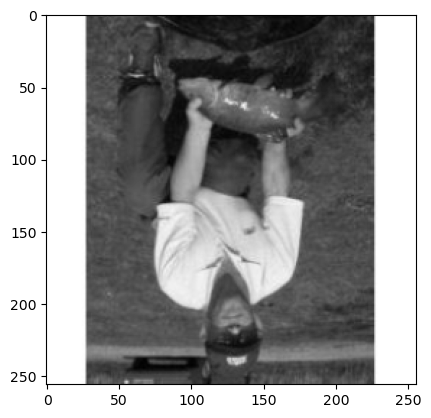

In [5]:
#Show an image from the dataset
image = train_dataset.get_grayscale_image(0)
plt.imshow(image[0], cmap='gray')


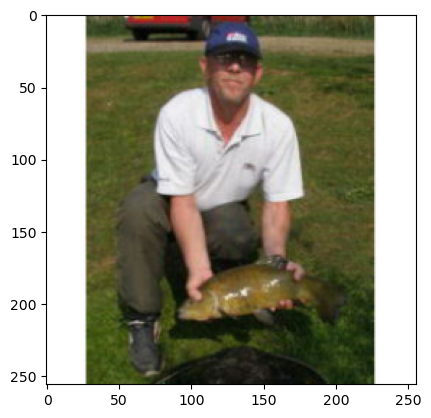

In [6]:
#Plot same image in colors
image = train_dataset.__getitem__(0)
plt.imshow(image.permute(1, 2, 0))

# UNET Autoencoder (Generator)
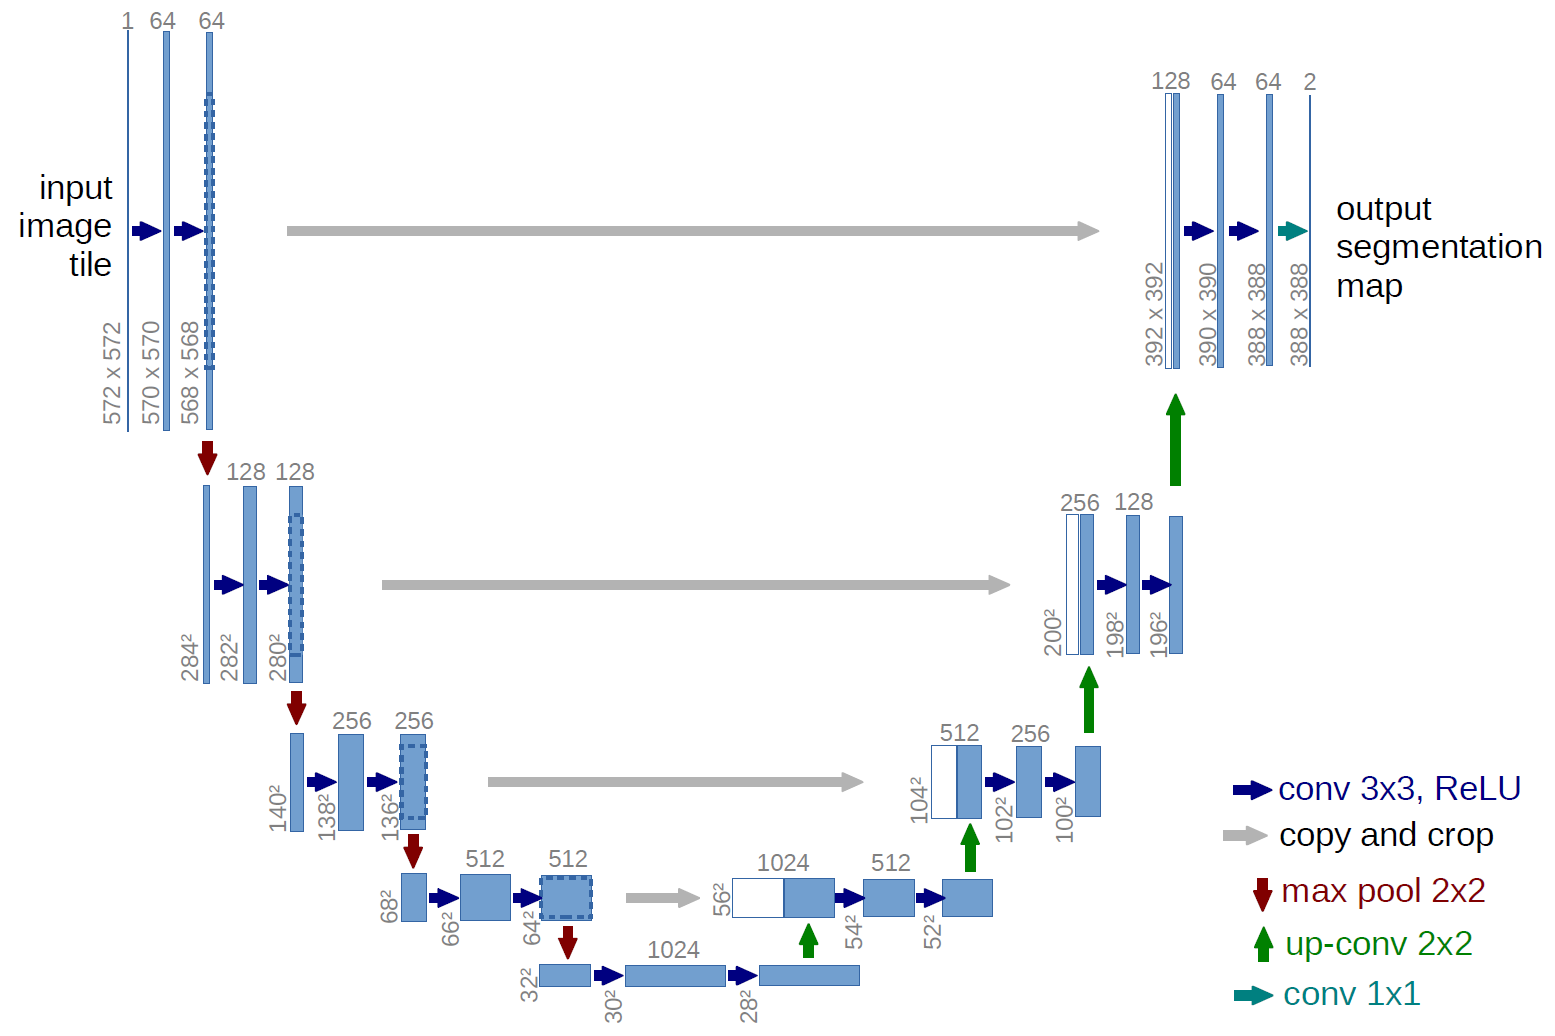

In [7]:
# Implement UNet autoencoder
class UNet(nn.Module):
    ## Constructor of the class 
    # Params:
    # in_channels= input image channels since in our case we are using grayscale images this is 1 for RGB images this would be 3
    # out_channels= outpute image channels since we want to get a colored image this is 3
    # featuress= list of numbers of output features for each block of the net (layer before max pooling) 
    # By default features are initialized like in the paper while in and out channel are already initialized how we want (can still be changed calling the constructor with different params) #
    def __init__(self, in_channels=1, out_channels=3,features=[64, 128, 256, 512]):
        super(UNet,self).__init__()
        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Encoder part of the network
        ## Iterate over the features list and create a double convolution block for each feature
        # after each iteration in_channels = feature since the next block in_channel is equals to the previous block output features
        # the bottom layer of the network is added later on#
        for feature in features:
            self.encoder_blocks.append(self.double_convolution(in_channels, feature))
            in_channels = feature
            # Maxpool not applied here because we need to save the output of the encoder block for the skip connection in the decoder part of the network
            
            
        # Decoder part of the network 
        # Iterate through the feature backwards (from the bottom to top of the image) #
        for feature in reversed(features):
            # Upconv part of the decoder block
            self.decoder_blocks.append(
                ## feature * 2 because the decoder block has 2 inputs 
                # (the output of the encoder block with skip connection and the output of the maxpooling of the previous decoder block)
                # kernel_size=2 and stride=2 upsample the image doubling width and height #
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
                )
            # Double convolution part of the decoder block 
            self.decoder_blocks.append(self.double_convolution(feature*2, feature))
        # Bottom layer of encoder/decoder part of the network
        # this layer is the last encoder block and first decoder block and as before uses doube convolution #
        self.bottom_layer = self.double_convolution(features[-1], features[-1]*2)
        # Final convolution layer of decoder part of the network 
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
    
    # Double convolution block utility function since both encoder and decoder have a double convolution for each block#
    def double_convolution(self,in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            # In the 2015 paper there was no batch normalization but it should be ok to add it
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    # Forward function of the network
    # Params:
    # self=self
    # x= input image
    def forward(self, x):
        # Store the skip connections for the decoder part of the network
        skip_connections = []
        # Encoder part of the network
        # Iterate over the encoder blocks and apply them to the input image
        # add x to the skip_connections list and then apply maxpool to x
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            skip_connections.append(x)
            x = self.maxpool(x)
        
        ## Bottom layer of the network
        # Apply the bottom layer to the output of the last encoder block #
        x = self.bottom_layer(x)
        # Decoder part of the network
        # Reverse the skip connections list to iterate from the bottom layer to the top one (List have been created from top to bottom)
        skip_connections = skip_connections[::-1]
        # Iterate over the decoder blocks and apply them to the input image
        # The starting index is 0 and the step is 2 because the decoder blocks list has 2 blocks for each layer (upconv and double convolution)
        for i in range(0, len(self.decoder_blocks), 2):
            # Get the skip connection for the current layer
            skip_connection = skip_connections[i//2]
            # Apply the upconv block to the input image
            x = self.decoder_blocks[i](x)

            ## Check if the output of the upconv block and the skip connection have the same size
            # If not crop the skip connection to the size of the output of the upconv block
            # In our use case should not be necessary since we resized images to 256x256 in the dataloader #
            if x.shape != skip_connection.shape:
                skip_connection = functional.interpolate(skip_connection, size=x.shape[2:])

            # Concatenate the output of the upconv block and the skip connection
            x = torch.cat((skip_connection, x), dim=1)
            # Apply the double convolution block to the concatenated image
            x = self.decoder_blocks[i+1](x)
        
        # Final convolution layer of the network
        return self.final_conv(x)




## Quick test to see if the unet model returns an image with the same shape than the original one

In [8]:

image = train_dataset.get_grayscale_image(0)
x = image.unsqueeze(0)
model = UNet()  
preds = model(x)
print(x.shape)
print(preds.shape)
## expected output:
# torch.Size([1, 1, 256, 256])
# torch.Size([1, 3, 256, 256]) 
# Output shape has 3 out channels since we want to go from grayscale to RGB #




torch.Size([1, 1, 256, 256])
torch.Size([1, 3, 256, 256])


# Discriminator

In [9]:
## Define the discriminator network (PatchGAN) 
# params:
# in_channels= channels of the input image + in channels of the unet output image (3 of input image + 3 of unet output image= 6)
# features: Number of out features for each conv block (as in UNet implementation) #
class Discriminator(nn.Module):
    def __init__(self, in_channels=6, features=[64, 128, 256, 512]):
        super().__init__()
        # Define the initial convolution block of the discriminator 
        self.initial= nn.Sequential(
            nn.Conv2d(in_channels, features[0], kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2)
        )
        # Define the rest of the convolution blocks of the discriminator
        self.layers = nn.ModuleList()
        in_channels = features[0]
        ## Iterate over the features list and apply a conv block to each element
        # The starting index is 1 because the first element of the features list is already used in the initial block
        # Stride is 2 for all the conv blocks except the last one #
        for i in range(1, len(features)):
            # Apply a conv block to the input image
            stride=1 if features[i] == features[-1] else 2
            self.layers.append(self.conv_block(features[i-1], features[i], stride))
            in_channels = features[i]
        # Add the final convolution block to the discriminator
        self.layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"))

    # Define the convolution blocks of the discriminator
    def conv_block(self, in_channels, out_channels, stride=2):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding_mode="reflect", bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    
    ## Define the forward function of the discriminator
    # params:
    # input_image= input image
    # unet_out_image= unet output image #
    def forward(self, input_image, unet_out_image):
        # Concatenate the input image and the unet output image
        x = torch.cat([input_image, unet_out_image], dim=1)
        # Apply the initial convolution block to the concatenated image
        x = self.initial(x)
        # Apply the rest of the convolution blocks to the output of the initial block
        for layer in self.layers:
            x = layer(x)
        
        return x


## Quick test to see if discriminator works

In [10]:
# Test the discriminator network
original_image = train_dataset.__getitem__(0)
grayscale_image = train_dataset.get_grayscale_image(0)
unet = UNet()
y = unet(grayscale_image.unsqueeze(0))
disc = Discriminator()
preds = disc(original_image.unsqueeze(0), y)
print(preds.shape)


torch.Size([1, 1, 26, 26])


## Training function

In [13]:

## Implement save_checkpoint function
# params:
# model= model to save
# optimizer= optimizer to save
# filename= name of the file to save the model
def save_checkpoint(model, optimizer, filename):
    state_dict = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict()
    }
    torch.save(state_dict, filename)

## Implement load_checkpoint function
# params:
# model= model to load
# optimizer= optimizer to load
# filename= name of the file to load the model
# lr= learning rate to use for the optimizer
def load_checkpoint(model, optimizer, filename, lr):
    state_dict = torch.load(filename)
    model.load_state_dict(state_dict["model_state_dict"])
    optimizer.load_state_dict(state_dict["optimizer_state_dict"])
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

## Save example images
# params:
# gen= generator network
# epoch= epoch number
#device= device to use
def save_examples(gen, epoch, device):
    # Load the images
    original_image = train_dataset.__getitem__(0)
    grayscale_image = train_dataset.get_grayscale_image(0)
    # Convert the images to tensors
    original_image = original_image.unsqueeze(0).to(device)
    grayscale_image = grayscale_image.unsqueeze(0).to(device)
    # Generate the image
    gen_image = gen(grayscale_image)
    # Save the images
    # Path to save the images in current folder
    path = "saved_samples/"
    # Create the path if it doesn't exist
    if not os.path.exists(path):
        os.makedirs(path)
    # Save the images
    # save_image(original_image, path + "original_image_" + str(epoch) + ".png")
    save_image(gen_image, path + "generated_image_" + str(epoch) + ".png")
    # save_image(grayscale_image, path + "grayscale_image_" + str(epoch) + ".png")


## Implement the training loop for the GAN
# params:
# epochs= number of epochs to train the model
# save_epoch= number of epochs to save the model
# loader= data loader
# gen= generator network
# disc= discriminator network
# opt_gen= optimizer for the generator
# opt_disc= optimizer for the discriminator
# l1= l1 loss function
# bce= bce loss function
# g_scaler= scaler for the generator
# d_scaler= scaler for the discriminator
# device= device to use
def train(epochs, save_epoch, loader, gen, disc, opt_gen, opt_disc, l1, bce, g_scaler, d_scaler, device):
    # Load checkpoint if it exists
    if os.path.exists("gen_checkpoint.pth.tar"):
        load_checkpoint(gen, opt_gen, "gen_checkpoint.pth.tar", opt_gen.param_groups[0]["lr"])
    if os.path.exists("disc_checkpoint.pth.tar"):
        load_checkpoint(disc, opt_disc, "disc_checkpoint.pth.tar", opt_disc.param_groups[0]["lr"])
    # Iterate over the epochs
    for epoch in range(epochs):
        # Iterate over the data loader
        for idx in range(len(loader)):
            grayscale_image = loader.get_grayscale_image(idx)
            original_image = loader.__getitem__(idx)
            # Move the images to the device
            original_image = original_image.to(device)
            grayscale_image = grayscale_image.to(device)
            # Unsqueeze the images
            original_image = original_image.unsqueeze(0)
            grayscale_image = grayscale_image.unsqueeze(0)
            # Train the discriminator
            # If cuda is enabled, use autocast
            if device == "cuda":
                with torch.cuda.amp.autocast():
                    # Generate the image
                    gen_image = gen(grayscale_image)
                    # Get the predictions from the discriminator
                    disc_real = disc(original_image, original_image)
                    disc_fake = disc(original_image, gen_image.detach())
                    # Calculate the discriminator loss
                    disc_loss = (bce(disc_real, torch.ones_like(disc_real)) + bce(disc_fake, torch.zeros_like(disc_fake)))/2
            else:
                # Generate the image
                gen_image = gen(grayscale_image)
                # Get the predictions from the discriminator
                disc_real = disc(original_image, original_image)
                disc_fake = disc(original_image, gen_image.detach())
                # Calculate the discriminator loss
                disc_loss = (bce(disc_real, torch.ones_like(disc_real)) + bce(disc_fake, torch.zeros_like(disc_fake)))/2
                
            # Backpropagate the discriminator loss
            opt_disc.zero_grad()
            d_scaler.scale(disc_loss).backward()
            d_scaler.step(opt_disc)
            d_scaler.update()
            # Train the generator
            # If cuda is enabled, use autocast
            if device == "cuda":
                with torch.cuda.amp.autocast():
                    # Get the predictions from the discriminator
                    disc_fake = disc(original_image, gen_image)
                    # Calculate the generator loss
                    gen_loss = bce(disc_fake, torch.ones_like(disc_fake)) + l1(gen_image, original_image) * 100
            else:
                # Get the predictions from the discriminator
                disc_fake = disc(original_image, gen_image)
                # Calculate the generator loss
                gen_loss = bce(disc_fake, torch.ones_like(disc_fake)) + l1(gen_image, original_image) * 100
            
            # Backpropagate the generator loss
            opt_gen.zero_grad()
            g_scaler.scale(gen_loss).backward()
            g_scaler.step(opt_gen)
            g_scaler.update()
            if idx % 100 == 0:
                # Print the losses
                print(f"Epoch: {epoch} | Batch: {idx} | Generator Loss: {gen_loss.item()} | Discriminator Loss: {disc_loss.item()}")
        #save checkpoint
        if epoch % save_epoch == 0:
            save_checkpoint(gen, opt_gen, "gen_checkpoint.pth.tar")
            save_checkpoint(disc, opt_disc, "disc_checkpoint.pth.tar")
        # Save some images
        save_examples(gen, epoch, device)

    


In [ ]:
## Train the model
# Define the hyperparameters
epochs = 100
save_epoch = 1
# Define the data loader
train_loader = ImageNetDataLoader(root, batch_size=8, shuffle=True, split='train', transform=train_transform, img_subset=80000, num_workers=8)
#Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Define the generator network
gen = UNet().to(device)
# Define the discriminator network
disc = Discriminator().to(device)
# Define the optimizers
opt_gen = torch.optim.Adam(gen.parameters(), lr=0.0005, betas=(0.5, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=0.0005, betas=(0.5, 0.999))
# Define the loss functions
l1 = nn.L1Loss()
bce = nn.BCEWithLogitsLoss()
#Define the scaler
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

# Train the model
train(epochs, save_epoch, train_loader, gen, disc, opt_gen, opt_disc, l1, bce, g_scaler, d_scaler, device)


cuda
Epoch: 0 | Batch: 0 | Generator Loss: 42.95451354980469 | Discriminator Loss: 1.5121584340249683e-07
Epoch: 0 | Batch: 100 | Generator Loss: 43.474937438964844 | Discriminator Loss: 4.684599446136417e-07
Epoch: 0 | Batch: 200 | Generator Loss: 45.39795684814453 | Discriminator Loss: 4.6175577494977915e-07
Epoch: 0 | Batch: 300 | Generator Loss: 35.698692321777344 | Discriminator Loss: 5.6186145229730755e-06
Epoch: 0 | Batch: 400 | Generator Loss: 33.32314682006836 | Discriminator Loss: 7.539604212070117e-07
Epoch: 0 | Batch: 500 | Generator Loss: 56.53729248046875 | Discriminator Loss: 7.715073735425904e-08
Epoch: 0 | Batch: 600 | Generator Loss: 41.50162124633789 | Discriminator Loss: 2.878823011087661e-07
Epoch: 0 | Batch: 700 | Generator Loss: 28.974414825439453 | Discriminator Loss: 4.558515058761259e-07
Epoch: 0 | Batch: 800 | Generator Loss: 26.94005012512207 | Discriminator Loss: 3.444896492510452e-07
Epoch: 0 | Batch: 900 | Generator Loss: 45.654747009277344 | Discriminato

Epoch: 0 | Batch: 8100 | Generator Loss: 35.275657653808594 | Discriminator Loss: 2.0456027982618252e-08
Epoch: 0 | Batch: 8200 | Generator Loss: 47.046382904052734 | Discriminator Loss: 1.1682291756187624e-07
Epoch: 0 | Batch: 8300 | Generator Loss: 33.52151107788086 | Discriminator Loss: 9.293375313745855e-08
Epoch: 0 | Batch: 8400 | Generator Loss: 39.707340240478516 | Discriminator Loss: 1.4901142542100843e-08
Epoch: 0 | Batch: 8500 | Generator Loss: 48.45654296875 | Discriminator Loss: 8.81725359391794e-10
Epoch: 0 | Batch: 8600 | Generator Loss: 42.915740966796875 | Discriminator Loss: 1.7634503857166806e-09
Epoch: 0 | Batch: 8700 | Generator Loss: 53.76486587524414 | Discriminator Loss: 3.8531094759264306e-08
Epoch: 0 | Batch: 8800 | Generator Loss: 53.88191223144531 | Discriminator Loss: 2.7774138544600646e-08
Epoch: 0 | Batch: 8900 | Generator Loss: 59.99713134765625 | Discriminator Loss: 1.2344153255128276e-08
Epoch: 0 | Batch: 9000 | Generator Loss: 48.929481506347656 | Disc

Epoch: 1 | Batch: 6100 | Generator Loss: 52.792579650878906 | Discriminator Loss: 2.2148863365600846e-07
Epoch: 1 | Batch: 6200 | Generator Loss: 45.888065338134766 | Discriminator Loss: 5.408377887761162e-07
Epoch: 1 | Batch: 6300 | Generator Loss: 36.530784606933594 | Discriminator Loss: 1.3481509313351125e-06
Epoch: 1 | Batch: 6400 | Generator Loss: 44.88788986206055 | Discriminator Loss: 4.4967986667643345e-08
Epoch: 1 | Batch: 6500 | Generator Loss: 35.813194274902344 | Discriminator Loss: 1.064242383108649e-07
Epoch: 1 | Batch: 6600 | Generator Loss: 28.29801368713379 | Discriminator Loss: 2.2247488232096657e-05
Epoch: 1 | Batch: 6700 | Generator Loss: 34.14278793334961 | Discriminator Loss: 9.290291927754879e-05
Epoch: 1 | Batch: 6800 | Generator Loss: 24.565406799316406 | Discriminator Loss: 0.0012178589822724462
Epoch: 1 | Batch: 6900 | Generator Loss: 37.72327423095703 | Discriminator Loss: 1.0243849146718276e-06
Epoch: 1 | Batch: 7000 | Generator Loss: 46.69403839111328 | Di

Epoch: 2 | Batch: 4100 | Generator Loss: 49.211421966552734 | Discriminator Loss: 7.582839245401374e-09
Epoch: 2 | Batch: 4200 | Generator Loss: 53.9927978515625 | Discriminator Loss: 0.0
Epoch: 2 | Batch: 4300 | Generator Loss: 42.669044494628906 | Discriminator Loss: 8.094224313026643e-08
Epoch: 2 | Batch: 4400 | Generator Loss: 50.903987884521484 | Discriminator Loss: 8.817254565363086e-11
Epoch: 2 | Batch: 4500 | Generator Loss: 48.47230911254883 | Discriminator Loss: 1.4636641232357306e-08
Epoch: 2 | Batch: 4600 | Generator Loss: 46.832157135009766 | Discriminator Loss: 5.958619340162841e-07
Epoch: 2 | Batch: 4700 | Generator Loss: 70.89730834960938 | Discriminator Loss: 8.51746193575309e-08
Epoch: 2 | Batch: 4800 | Generator Loss: 22.481355667114258 | Discriminator Loss: 0.0009422303410246968
Epoch: 2 | Batch: 4900 | Generator Loss: 28.905658721923828 | Discriminator Loss: 0.0001061317598214373
Epoch: 2 | Batch: 5000 | Generator Loss: 54.483299255371094 | Discriminator Loss: 7.05

Epoch: 3 | Batch: 2200 | Generator Loss: 41.07262420654297 | Discriminator Loss: 2.0932149880081852e-07
Epoch: 3 | Batch: 2300 | Generator Loss: 50.83885955810547 | Discriminator Loss: 1.781964300562322e-07
Epoch: 3 | Batch: 2400 | Generator Loss: 28.070266723632812 | Discriminator Loss: 1.9531885300239082e-06
Epoch: 3 | Batch: 2500 | Generator Loss: 40.23109436035156 | Discriminator Loss: 5.25772293258342e-07
Epoch: 3 | Batch: 2600 | Generator Loss: 38.74211502075195 | Discriminator Loss: 7.101406254150788e-07
Epoch: 3 | Batch: 2700 | Generator Loss: 35.620697021484375 | Discriminator Loss: 2.070289752964527e-07
Epoch: 3 | Batch: 2800 | Generator Loss: 37.18989562988281 | Discriminator Loss: 1.3626157624457846e-06
Epoch: 3 | Batch: 2900 | Generator Loss: 46.13816833496094 | Discriminator Loss: 6.011586037857342e-07
Epoch: 3 | Batch: 3000 | Generator Loss: 44.579586029052734 | Discriminator Loss: 6.224981063951418e-08
Epoch: 3 | Batch: 3100 | Generator Loss: 30.577529907226562 | Discri

Epoch: 4 | Batch: 200 | Generator Loss: 50.061500549316406 | Discriminator Loss: 2.530549991774933e-08
Epoch: 4 | Batch: 300 | Generator Loss: 39.97886657714844 | Discriminator Loss: 1.3807814980282274e-07
Epoch: 4 | Batch: 400 | Generator Loss: 34.483001708984375 | Discriminator Loss: 3.5753362226387253e-07
Epoch: 4 | Batch: 500 | Generator Loss: 56.02290344238281 | Discriminator Loss: 1.2089409437976428e-06
Epoch: 4 | Batch: 600 | Generator Loss: 33.77943801879883 | Discriminator Loss: 3.8072326447036176e-07
Epoch: 4 | Batch: 700 | Generator Loss: 42.36547088623047 | Discriminator Loss: 1.1889911775142536e-06
Epoch: 4 | Batch: 800 | Generator Loss: 33.04766845703125 | Discriminator Loss: 7.779148063491448e-07
Epoch: 4 | Batch: 900 | Generator Loss: 46.37222671508789 | Discriminator Loss: 5.554863946599653e-08
Epoch: 4 | Batch: 1000 | Generator Loss: 36.198734283447266 | Discriminator Loss: 4.300611180951819e-06
Epoch: 4 | Batch: 1100 | Generator Loss: 51.34654235839844 | Discriminato

Epoch: 4 | Batch: 8200 | Generator Loss: 48.073089599609375 | Discriminator Loss: 9.610804596604794e-09
Epoch: 4 | Batch: 8300 | Generator Loss: 34.38652038574219 | Discriminator Loss: 5.105189870846516e-08
Epoch: 4 | Batch: 8400 | Generator Loss: 35.621028900146484 | Discriminator Loss: 2.008570305633839e-07
Epoch: 4 | Batch: 8500 | Generator Loss: 45.04157638549805 | Discriminator Loss: 6.083899961595307e-08
Epoch: 4 | Batch: 8600 | Generator Loss: 41.33230972290039 | Discriminator Loss: 7.847356542356465e-09
Epoch: 4 | Batch: 8700 | Generator Loss: 52.90721893310547 | Discriminator Loss: 0.0
Epoch: 4 | Batch: 8800 | Generator Loss: 55.87516403198242 | Discriminator Loss: 2.645176300219987e-10
Epoch: 4 | Batch: 8900 | Generator Loss: 62.20184326171875 | Discriminator Loss: 2.3806585591756857e-09
Epoch: 4 | Batch: 9000 | Generator Loss: 41.118247985839844 | Discriminator Loss: 9.963496694354035e-09
Epoch: 4 | Batch: 9100 | Generator Loss: 50.74351119995117 | Discriminator Loss: 3.1389

Epoch: 5 | Batch: 6300 | Generator Loss: 36.71842575073242 | Discriminator Loss: 1.3666744180795831e-08
Epoch: 5 | Batch: 6400 | Generator Loss: 47.05164337158203 | Discriminator Loss: 4.937662279047572e-09
Epoch: 5 | Batch: 6500 | Generator Loss: 42.397308349609375 | Discriminator Loss: 1.9397958794797887e-09
Epoch: 5 | Batch: 6600 | Generator Loss: 38.43238830566406 | Discriminator Loss: 2.2924862008721902e-09
Epoch: 5 | Batch: 6700 | Generator Loss: 36.80943298339844 | Discriminator Loss: 1.4636636791465207e-08
Epoch: 5 | Batch: 6800 | Generator Loss: 32.80800247192383 | Discriminator Loss: 2.109968448849031e-07
Epoch: 5 | Batch: 6900 | Generator Loss: 42.753517150878906 | Discriminator Loss: 9.751882146247226e-08
Epoch: 5 | Batch: 7000 | Generator Loss: 47.849891662597656 | Discriminator Loss: 0.0
Epoch: 5 | Batch: 7100 | Generator Loss: 43.986854553222656 | Discriminator Loss: 2.9802290413272203e-08
Epoch: 5 | Batch: 7200 | Generator Loss: 59.0644416809082 | Discriminator Loss: 0.

Epoch: 6 | Batch: 4500 | Generator Loss: 45.58953094482422 | Discriminator Loss: 4.320449775718771e-08
Epoch: 6 | Batch: 4600 | Generator Loss: 44.328609466552734 | Discriminator Loss: 1.1330135407661146e-07
Epoch: 6 | Batch: 4700 | Generator Loss: 55.01911163330078 | Discriminator Loss: 2.9185104111206783e-08
Epoch: 6 | Batch: 4800 | Generator Loss: 43.78982925415039 | Discriminator Loss: 3.3681899935800175e-08
Epoch: 6 | Batch: 4900 | Generator Loss: 73.05990600585938 | Discriminator Loss: 5.0258348593956725e-09
Epoch: 6 | Batch: 5000 | Generator Loss: 40.39617919921875 | Discriminator Loss: 5.554867499313332e-08
Epoch: 6 | Batch: 5100 | Generator Loss: 63.95619201660156 | Discriminator Loss: 9.787152421836254e-09
Epoch: 6 | Batch: 5200 | Generator Loss: 43.46256637573242 | Discriminator Loss: 6.366055060880171e-08
Epoch: 6 | Batch: 5300 | Generator Loss: 48.01397705078125 | Discriminator Loss: 3.39464278908963e-08
Epoch: 6 | Batch: 5400 | Generator Loss: 47.69654083251953 | Discrimi

Epoch: 7 | Batch: 2500 | Generator Loss: 54.15876770019531 | Discriminator Loss: 1.1100726027279961e-07
Epoch: 7 | Batch: 2600 | Generator Loss: 51.8270378112793 | Discriminator Loss: 9.434444336875458e-09
Epoch: 7 | Batch: 2700 | Generator Loss: 48.312313079833984 | Discriminator Loss: 5.290352600439974e-10
Epoch: 7 | Batch: 2800 | Generator Loss: 38.444419860839844 | Discriminator Loss: 2.730700998654356e-07
Epoch: 7 | Batch: 2900 | Generator Loss: 48.38029861450195 | Discriminator Loss: 1.1920923270736239e-07
Epoch: 7 | Batch: 3000 | Generator Loss: 55.11000442504883 | Discriminator Loss: 2.4511958685025093e-08
Epoch: 7 | Batch: 3100 | Generator Loss: 40.186126708984375 | Discriminator Loss: 6.6129408615722696e-09
Epoch: 7 | Batch: 3200 | Generator Loss: 37.872283935546875 | Discriminator Loss: 6.366052218709228e-08
Epoch: 7 | Batch: 3300 | Generator Loss: 36.308441162109375 | Discriminator Loss: 2.0367853181824103e-08
Epoch: 7 | Batch: 3400 | Generator Loss: 47.412567138671875 | Di

Epoch: 8 | Batch: 500 | Generator Loss: 62.240623474121094 | Discriminator Loss: 0.0
Epoch: 8 | Batch: 600 | Generator Loss: 40.2034912109375 | Discriminator Loss: 1.8251714806183372e-08
Epoch: 8 | Batch: 700 | Generator Loss: 42.293277740478516 | Discriminator Loss: 1.0757049473397728e-08
Epoch: 8 | Batch: 800 | Generator Loss: 37.063602447509766 | Discriminator Loss: 2.8391500705993167e-08
Epoch: 8 | Batch: 900 | Generator Loss: 47.91594314575195 | Discriminator Loss: 9.522629795810644e-09
Epoch: 8 | Batch: 1000 | Generator Loss: 48.568153381347656 | Discriminator Loss: 1.4989331997838917e-09
Epoch: 8 | Batch: 1100 | Generator Loss: 44.27046203613281 | Discriminator Loss: 1.4989331997838917e-09
Epoch: 8 | Batch: 1200 | Generator Loss: 52.26737976074219 | Discriminator Loss: 7.4064927524375435e-09
Epoch: 8 | Batch: 1300 | Generator Loss: 40.517295837402344 | Discriminator Loss: 5.290352600439974e-10
Epoch: 8 | Batch: 1400 | Generator Loss: 38.14211654663086 | Discriminator Loss: 3.744

Epoch: 8 | Batch: 8600 | Generator Loss: 57.008392333984375 | Discriminator Loss: 1.5871057801319921e-09
Epoch: 8 | Batch: 8700 | Generator Loss: 37.89600372314453 | Discriminator Loss: 1.4989331997838917e-09
Epoch: 8 | Batch: 8800 | Generator Loss: 32.42168045043945 | Discriminator Loss: 4.558510369179203e-08
Epoch: 8 | Batch: 8900 | Generator Loss: 79.22315979003906 | Discriminator Loss: 7.036132387838734e-08
Epoch: 8 | Batch: 9000 | Generator Loss: 57.81818771362305 | Discriminator Loss: 0.0
Epoch: 8 | Batch: 9100 | Generator Loss: 68.38911437988281 | Discriminator Loss: 3.0941064323997125e-06
Epoch: 8 | Batch: 9200 | Generator Loss: 54.08644485473633 | Discriminator Loss: 0.00010262394789606333
Epoch: 8 | Batch: 9300 | Generator Loss: 42.92053985595703 | Discriminator Loss: 3.7032468203079816e-09
Epoch: 8 | Batch: 9400 | Generator Loss: 78.53285217285156 | Discriminator Loss: 3.156573669116369e-08
Epoch: 8 | Batch: 9500 | Generator Loss: 75.34292602539062 | Discriminator Loss: 3.26

Epoch: 9 | Batch: 6600 | Generator Loss: 45.61339569091797 | Discriminator Loss: 0.0
Epoch: 9 | Batch: 6700 | Generator Loss: 39.13380813598633 | Discriminator Loss: 1.84834323135874e-06
Epoch: 9 | Batch: 6800 | Generator Loss: 25.65407943725586 | Discriminator Loss: 1.0563841215116554e-06
Epoch: 9 | Batch: 6900 | Generator Loss: 48.18645095825195 | Discriminator Loss: 3.2623841406120846e-09
Epoch: 9 | Batch: 7000 | Generator Loss: 52.03352355957031 | Discriminator Loss: 1.7634509130726173e-10
Epoch: 9 | Batch: 7100 | Generator Loss: 45.347808837890625 | Discriminator Loss: 2.0711440811282955e-06
Epoch: 9 | Batch: 7200 | Generator Loss: 63.27678680419922 | Discriminator Loss: 1.0051669718791345e-08
Epoch: 9 | Batch: 7300 | Generator Loss: 50.23695755004883 | Discriminator Loss: 9.522624111468758e-08
Epoch: 9 | Batch: 7400 | Generator Loss: 50.43463134765625 | Discriminator Loss: 5.995732355046357e-09
Epoch: 9 | Batch: 7500 | Generator Loss: 50.431800842285156 | Discriminator Loss: 1.23

Epoch: 10 | Batch: 4700 | Generator Loss: 55.798133850097656 | Discriminator Loss: 1.46541538015299e-07
Epoch: 10 | Batch: 4800 | Generator Loss: 43.211708068847656 | Discriminator Loss: 1.5871055580873872e-08
Epoch: 10 | Batch: 4900 | Generator Loss: 49.953060150146484 | Discriminator Loss: 2.5570034978272815e-09
Epoch: 10 | Batch: 5000 | Generator Loss: 42.62084197998047 | Discriminator Loss: 1.9168483333942277e-07
Epoch: 10 | Batch: 5100 | Generator Loss: 62.522308349609375 | Discriminator Loss: 6.85976857539572e-08
Epoch: 10 | Batch: 5200 | Generator Loss: 42.53680419921875 | Discriminator Loss: 3.3505521912502445e-08
Epoch: 10 | Batch: 5300 | Generator Loss: 48.858177185058594 | Discriminator Loss: 3.906042067569615e-08
Epoch: 10 | Batch: 5400 | Generator Loss: 46.37431335449219 | Discriminator Loss: 1.871013353138551e-07
Epoch: 10 | Batch: 5500 | Generator Loss: 46.7610969543457 | Discriminator Loss: 8.023700814874246e-09
Epoch: 10 | Batch: 5600 | Generator Loss: 61.6274337768554

Epoch: 11 | Batch: 2600 | Generator Loss: 36.887481689453125 | Discriminator Loss: 9.549279411658063e-07
Epoch: 11 | Batch: 2700 | Generator Loss: 35.79426574707031 | Discriminator Loss: 3.324104369539782e-08
Epoch: 11 | Batch: 2800 | Generator Loss: 33.503746032714844 | Discriminator Loss: 8.462712912660209e-07
Epoch: 11 | Batch: 2900 | Generator Loss: 42.82374954223633 | Discriminator Loss: 2.6310655698580376e-07
Epoch: 11 | Batch: 3000 | Generator Loss: 45.25132751464844 | Discriminator Loss: 9.169943915310341e-09
Epoch: 11 | Batch: 3100 | Generator Loss: 29.102821350097656 | Discriminator Loss: 2.3744823351989908e-07
Epoch: 11 | Batch: 3200 | Generator Loss: 32.182838439941406 | Discriminator Loss: 1.801364106768233e-07
Epoch: 11 | Batch: 3300 | Generator Loss: 30.041034698486328 | Discriminator Loss: 9.257212241209345e-07
Epoch: 11 | Batch: 3400 | Generator Loss: 34.947818756103516 | Discriminator Loss: 2.54817138056751e-07
Epoch: 11 | Batch: 3500 | Generator Loss: 35.220130920410

Epoch: 12 | Batch: 500 | Generator Loss: 48.57671356201172 | Discriminator Loss: 2.239580076945913e-08
Epoch: 12 | Batch: 600 | Generator Loss: 47.86615753173828 | Discriminator Loss: 6.145619124708901e-08
Epoch: 12 | Batch: 700 | Generator Loss: 39.98396301269531 | Discriminator Loss: 9.857673433089076e-08
Epoch: 12 | Batch: 800 | Generator Loss: 41.73529815673828 | Discriminator Loss: 5.320259219843138e-07
Epoch: 12 | Batch: 900 | Generator Loss: 48.73992919921875 | Discriminator Loss: 3.225284785912663e-07
Epoch: 12 | Batch: 1000 | Generator Loss: 51.58611297607422 | Discriminator Loss: 2.2219465378725545e-08
Epoch: 12 | Batch: 1100 | Generator Loss: 49.142364501953125 | Discriminator Loss: 7.432939952423112e-08
Epoch: 12 | Batch: 1200 | Generator Loss: 56.13340759277344 | Discriminator Loss: 4.7030601990627474e-07
Epoch: 12 | Batch: 1300 | Generator Loss: 45.58480453491211 | Discriminator Loss: 9.875324558095144e-09
Epoch: 12 | Batch: 1400 | Generator Loss: 42.632354736328125 | Dis

Epoch: 12 | Batch: 8400 | Generator Loss: 33.680908203125 | Discriminator Loss: 9.63455477176467e-07
Epoch: 12 | Batch: 8500 | Generator Loss: 48.85778045654297 | Discriminator Loss: 1.1462431004360951e-09
Epoch: 12 | Batch: 8600 | Generator Loss: 38.50933837890625 | Discriminator Loss: 3.985398677741614e-08
Epoch: 12 | Batch: 8700 | Generator Loss: 53.25712203979492 | Discriminator Loss: 2.645176300219987e-10
Epoch: 12 | Batch: 8800 | Generator Loss: 50.24053192138672 | Discriminator Loss: 2.5570037198718865e-09
Epoch: 12 | Batch: 8900 | Generator Loss: 60.04920959472656 | Discriminator Loss: 0.0
Epoch: 12 | Batch: 9000 | Generator Loss: 44.855403900146484 | Discriminator Loss: 4.49679937730707e-09
Epoch: 12 | Batch: 9100 | Generator Loss: 47.340293884277344 | Discriminator Loss: 1.7634508298058904e-09
Epoch: 12 | Batch: 9200 | Generator Loss: 50.10759735107422 | Discriminator Loss: 2.451196401409561e-08
Epoch: 12 | Batch: 9300 | Generator Loss: 40.64588165283203 | Discriminator Loss:

Epoch: 13 | Batch: 6300 | Generator Loss: 57.41978454589844 | Discriminator Loss: 3.145907783164148e-07
Epoch: 13 | Batch: 6400 | Generator Loss: 71.63909912109375 | Discriminator Loss: 4.117656615676424e-08
Epoch: 13 | Batch: 6500 | Generator Loss: 63.39043045043945 | Discriminator Loss: 9.686555858934298e-05
Epoch: 13 | Batch: 6600 | Generator Loss: 45.18138885498047 | Discriminator Loss: 6.604116009611971e-08
Epoch: 13 | Batch: 6700 | Generator Loss: 39.827369689941406 | Discriminator Loss: 5.556295832320757e-07
Epoch: 13 | Batch: 6800 | Generator Loss: 39.584754943847656 | Discriminator Loss: 8.112141586025245e-06
Epoch: 13 | Batch: 6900 | Generator Loss: 57.293704986572266 | Discriminator Loss: 0.00014426244888454676
Epoch: 13 | Batch: 7000 | Generator Loss: 61.426334381103516 | Discriminator Loss: 1.424425363438786e-06
Epoch: 13 | Batch: 7100 | Generator Loss: 42.39879608154297 | Discriminator Loss: 5.734664796364086e-07
Epoch: 13 | Batch: 7200 | Generator Loss: 77.55361938476562

Epoch: 14 | Batch: 4200 | Generator Loss: 45.837127685546875 | Discriminator Loss: 3.271201265420132e-08
Epoch: 14 | Batch: 4300 | Generator Loss: 38.178466796875 | Discriminator Loss: 1.551836703583831e-08
Epoch: 14 | Batch: 4400 | Generator Loss: 50.93454360961914 | Discriminator Loss: 1.7634509130726173e-10
Epoch: 14 | Batch: 4500 | Generator Loss: 39.346134185791016 | Discriminator Loss: 3.967761674772419e-09
Epoch: 14 | Batch: 4600 | Generator Loss: 38.03527069091797 | Discriminator Loss: 1.1376870361345937e-06
Epoch: 14 | Batch: 4700 | Generator Loss: 54.958984375 | Discriminator Loss: 7.935528900659961e-10
Epoch: 14 | Batch: 4800 | Generator Loss: 37.44841766357422 | Discriminator Loss: 1.0060472988016045e-07
Epoch: 14 | Batch: 4900 | Generator Loss: 75.72344207763672 | Discriminator Loss: 8.817254565363086e-11
Epoch: 14 | Batch: 5000 | Generator Loss: 36.102203369140625 | Discriminator Loss: 1.35080313157232e-07
Epoch: 14 | Batch: 5100 | Generator Loss: 60.537872314453125 | Dis

Epoch: 15 | Batch: 2400 | Generator Loss: 31.325748443603516 | Discriminator Loss: 4.664326880288172e-08
Epoch: 15 | Batch: 2500 | Generator Loss: 44.43695831298828 | Discriminator Loss: 2.3806585591756857e-09
Epoch: 15 | Batch: 2600 | Generator Loss: 39.815521240234375 | Discriminator Loss: 3.350556720960185e-09
Epoch: 15 | Batch: 2700 | Generator Loss: 44.20290756225586 | Discriminator Loss: 0.0
Epoch: 15 | Batch: 2800 | Generator Loss: 40.25775909423828 | Discriminator Loss: 3.8795917589595774e-09
Epoch: 15 | Batch: 2900 | Generator Loss: 48.534912109375 | Discriminator Loss: 1.5430194011401e-08
Epoch: 15 | Batch: 3000 | Generator Loss: 55.42274475097656 | Discriminator Loss: 0.0
Epoch: 15 | Batch: 3100 | Generator Loss: 36.77581787109375 | Discriminator Loss: 3.5269018261452345e-10
Epoch: 15 | Batch: 3200 | Generator Loss: 42.973854064941406 | Discriminator Loss: 0.0
Epoch: 15 | Batch: 3300 | Generator Loss: 35.11542892456055 | Discriminator Loss: 2.671627719053049e-08
Epoch: 15 | 

Epoch: 16 | Batch: 1300 | Generator Loss: 47.832454681396484 | Discriminator Loss: 0.0
Epoch: 16 | Batch: 1400 | Generator Loss: 45.69535827636719 | Discriminator Loss: 0.0
Epoch: 16 | Batch: 1500 | Generator Loss: 56.05044174194336 | Discriminator Loss: 0.0
Epoch: 16 | Batch: 1600 | Generator Loss: 51.955963134765625 | Discriminator Loss: 0.0
Epoch: 16 | Batch: 1700 | Generator Loss: 44.39201736450195 | Discriminator Loss: 0.0
Epoch: 16 | Batch: 1800 | Generator Loss: 45.35136413574219 | Discriminator Loss: 0.0
Epoch: 16 | Batch: 1900 | Generator Loss: 54.85637664794922 | Discriminator Loss: 0.0
Epoch: 16 | Batch: 2000 | Generator Loss: 49.68269729614258 | Discriminator Loss: 0.0
Epoch: 16 | Batch: 2100 | Generator Loss: 44.714805603027344 | Discriminator Loss: 0.0
Epoch: 16 | Batch: 2200 | Generator Loss: 51.84317398071289 | Discriminator Loss: 0.0
Epoch: 16 | Batch: 2300 | Generator Loss: 68.90060424804688 | Discriminator Loss: 0.0
Epoch: 16 | Batch: 2400 | Generator Loss: 36.336097

Epoch: 16 | Batch: 9700 | Generator Loss: 38.2073860168457 | Discriminator Loss: 1.1374255315388382e-08
Epoch: 16 | Batch: 9800 | Generator Loss: 39.04698944091797 | Discriminator Loss: 2.026198870908047e-07
Epoch: 16 | Batch: 9900 | Generator Loss: 43.75053024291992 | Discriminator Loss: 1.7634509130726173e-10
Epoch: 17 | Batch: 0 | Generator Loss: 50.06383514404297 | Discriminator Loss: 1.763450718783588e-09
Epoch: 17 | Batch: 100 | Generator Loss: 40.08958435058594 | Discriminator Loss: 8.464563272525538e-09
Epoch: 17 | Batch: 200 | Generator Loss: 49.51008605957031 | Discriminator Loss: 7.053803097178957e-10
Epoch: 17 | Batch: 300 | Generator Loss: 44.414127349853516 | Discriminator Loss: 1.3225881501099934e-09
Epoch: 17 | Batch: 400 | Generator Loss: 40.042877197265625 | Discriminator Loss: 2.645176078175382e-09
Epoch: 17 | Batch: 500 | Generator Loss: 42.682403564453125 | Discriminator Loss: 3.4563633732886956e-08
Epoch: 17 | Batch: 600 | Generator Loss: 49.341026306152344 | Disc

Epoch: 17 | Batch: 7800 | Generator Loss: 48.30747985839844 | Discriminator Loss: 0.0
Epoch: 17 | Batch: 7900 | Generator Loss: 46.99980926513672 | Discriminator Loss: 1.5871057801319921e-09
Epoch: 17 | Batch: 8000 | Generator Loss: 38.624412536621094 | Discriminator Loss: 2.2880757910570537e-07
Epoch: 17 | Batch: 8100 | Generator Loss: 35.76261520385742 | Discriminator Loss: 6.269065977448918e-08
Epoch: 17 | Batch: 8200 | Generator Loss: 44.46666717529297 | Discriminator Loss: 2.645176300219987e-10
Epoch: 17 | Batch: 8300 | Generator Loss: 34.20307922363281 | Discriminator Loss: 5.819387283167998e-08
Epoch: 17 | Batch: 8400 | Generator Loss: 37.246726989746094 | Discriminator Loss: 3.112490531975709e-08
Epoch: 17 | Batch: 8500 | Generator Loss: 45.782630920410156 | Discriminator Loss: 1.1462429894137927e-09
Epoch: 17 | Batch: 8600 | Generator Loss: 42.12846374511719 | Discriminator Loss: 7.053803652290469e-10
Epoch: 17 | Batch: 8700 | Generator Loss: 56.688987731933594 | Discriminator

Epoch: 18 | Batch: 5800 | Generator Loss: 35.57326126098633 | Discriminator Loss: 3.086038979915884e-09
Epoch: 18 | Batch: 5900 | Generator Loss: 41.11618423461914 | Discriminator Loss: 8.90542661835525e-09
Epoch: 18 | Batch: 6000 | Generator Loss: 59.71912384033203 | Discriminator Loss: 0.0
Epoch: 18 | Batch: 6100 | Generator Loss: 56.294090270996094 | Discriminator Loss: 0.0
Epoch: 18 | Batch: 6200 | Generator Loss: 38.227806091308594 | Discriminator Loss: 3.4387284131298657e-08
Epoch: 18 | Batch: 6300 | Generator Loss: 31.293020248413086 | Discriminator Loss: 7.018533665359428e-08
Epoch: 18 | Batch: 6400 | Generator Loss: 41.336341857910156 | Discriminator Loss: 2.2660342935409972e-08
Epoch: 18 | Batch: 6500 | Generator Loss: 48.66364288330078 | Discriminator Loss: 1.1462431004360951e-09
Epoch: 18 | Batch: 6600 | Generator Loss: 37.496456146240234 | Discriminator Loss: 2.027968459827889e-09
Epoch: 18 | Batch: 6700 | Generator Loss: 37.574283599853516 | Discriminator Loss: 4.23228208

Epoch: 19 | Batch: 3900 | Generator Loss: 31.335617065429688 | Discriminator Loss: 5.333550348041172e-07
Epoch: 19 | Batch: 4000 | Generator Loss: 48.55828857421875 | Discriminator Loss: 0.0
Epoch: 19 | Batch: 4100 | Generator Loss: 60.283111572265625 | Discriminator Loss: 0.0
Epoch: 19 | Batch: 4200 | Generator Loss: 51.641151428222656 | Discriminator Loss: 0.0
Epoch: 19 | Batch: 4300 | Generator Loss: 44.85258865356445 | Discriminator Loss: 7.053803097178957e-10
Epoch: 19 | Batch: 4400 | Generator Loss: 50.027427673339844 | Discriminator Loss: 0.0
Epoch: 19 | Batch: 4500 | Generator Loss: 41.26746368408203 | Discriminator Loss: 0.0
Epoch: 19 | Batch: 4600 | Generator Loss: 38.850677490234375 | Discriminator Loss: 1.0386724369482181e-07
Epoch: 19 | Batch: 4700 | Generator Loss: 49.76442337036133 | Discriminator Loss: 0.0
Epoch: 19 | Batch: 4800 | Generator Loss: 40.82008743286133 | Discriminator Loss: 8.817254149029452e-10
Epoch: 19 | Batch: 4900 | Generator Loss: 70.76370239257812 | 

Epoch: 20 | Batch: 2600 | Generator Loss: 52.04957580566406 | Discriminator Loss: 0.0
Epoch: 20 | Batch: 2700 | Generator Loss: 51.0213623046875 | Discriminator Loss: 0.0
Epoch: 20 | Batch: 2800 | Generator Loss: 41.829185485839844 | Discriminator Loss: 6.38455730950227e-07
Epoch: 20 | Batch: 2900 | Generator Loss: 52.05725860595703 | Discriminator Loss: 0.0
Epoch: 20 | Batch: 3000 | Generator Loss: 58.1375846862793 | Discriminator Loss: 0.0
Epoch: 20 | Batch: 3100 | Generator Loss: 46.160430908203125 | Discriminator Loss: 1.7634509130726173e-10
Epoch: 20 | Batch: 3200 | Generator Loss: 43.3314094543457 | Discriminator Loss: 0.0
Epoch: 20 | Batch: 3300 | Generator Loss: 42.505584716796875 | Discriminator Loss: 0.0
Epoch: 20 | Batch: 3400 | Generator Loss: 51.59477233886719 | Discriminator Loss: 0.0
Epoch: 20 | Batch: 3500 | Generator Loss: 40.68799591064453 | Discriminator Loss: 0.0
Epoch: 20 | Batch: 3600 | Generator Loss: 37.36970520019531 | Discriminator Loss: 7.053803652290469e-10


Epoch: 21 | Batch: 800 | Generator Loss: 33.225685119628906 | Discriminator Loss: 3.7071436054247897e-06
Epoch: 21 | Batch: 900 | Generator Loss: 51.285865783691406 | Discriminator Loss: 4.761315608448058e-08
Epoch: 21 | Batch: 1000 | Generator Loss: 53.543365478515625 | Discriminator Loss: 4.179377910418225e-08
Epoch: 21 | Batch: 1100 | Generator Loss: 42.07672882080078 | Discriminator Loss: 2.42474015976768e-07
Epoch: 21 | Batch: 1200 | Generator Loss: 56.935333251953125 | Discriminator Loss: 1.789902626114781e-08
Epoch: 21 | Batch: 1300 | Generator Loss: 47.28887176513672 | Discriminator Loss: 2.3012958649815118e-07
Epoch: 21 | Batch: 1400 | Generator Loss: 49.083168029785156 | Discriminator Loss: 4.435075595665694e-08
Epoch: 21 | Batch: 1500 | Generator Loss: 56.217437744140625 | Discriminator Loss: 3.9765794213053596e-08
Epoch: 21 | Batch: 1600 | Generator Loss: 54.495426177978516 | Discriminator Loss: 9.698972291971586e-08
Epoch: 21 | Batch: 1700 | Generator Loss: 38.220775604248

Epoch: 21 | Batch: 9000 | Generator Loss: 44.1478271484375 | Discriminator Loss: 7.424125669786008e-08
Epoch: 21 | Batch: 9100 | Generator Loss: 51.317054748535156 | Discriminator Loss: 1.1462430116182531e-08
Epoch: 21 | Batch: 9200 | Generator Loss: 55.693546295166016 | Discriminator Loss: 3.7737830638207015e-08
Epoch: 21 | Batch: 9300 | Generator Loss: 41.12401580810547 | Discriminator Loss: 4.02066753224517e-08
Epoch: 21 | Batch: 9400 | Generator Loss: 64.60200500488281 | Discriminator Loss: 4.408627074514726e-10
Epoch: 21 | Batch: 9500 | Generator Loss: 48.844627380371094 | Discriminator Loss: 3.4387293013082854e-09
Epoch: 21 | Batch: 9600 | Generator Loss: 37.67835998535156 | Discriminator Loss: 1.3225877637523809e-07
Epoch: 21 | Batch: 9700 | Generator Loss: 32.28746032714844 | Discriminator Loss: 1.020595391310053e-06
Epoch: 21 | Batch: 9800 | Generator Loss: 37.08842468261719 | Discriminator Loss: 1.0354078767704777e-06
Epoch: 21 | Batch: 9900 | Generator Loss: 37.6362648010253

Epoch: 22 | Batch: 7200 | Generator Loss: 52.43585205078125 | Discriminator Loss: 0.0
Epoch: 22 | Batch: 7300 | Generator Loss: 47.50469207763672 | Discriminator Loss: 1.5871057801319921e-09
Epoch: 22 | Batch: 7400 | Generator Loss: 43.6385498046875 | Discriminator Loss: 8.817254149029452e-10
Epoch: 22 | Batch: 7500 | Generator Loss: 39.323875427246094 | Discriminator Loss: 4.673144360367587e-08
Epoch: 22 | Batch: 7600 | Generator Loss: 38.22534942626953 | Discriminator Loss: 1.7634509130726173e-10
Epoch: 22 | Batch: 7700 | Generator Loss: 43.877418518066406 | Discriminator Loss: 1.093339285773709e-08
Epoch: 22 | Batch: 7800 | Generator Loss: 48.287086486816406 | Discriminator Loss: 0.0
Epoch: 22 | Batch: 7900 | Generator Loss: 38.273921966552734 | Discriminator Loss: 1.3314050306689751e-08
Epoch: 22 | Batch: 8000 | Generator Loss: 38.58235168457031 | Discriminator Loss: 5.14221596858988e-07
Epoch: 22 | Batch: 8100 | Generator Loss: 35.26333999633789 | Discriminator Loss: 5.46669776113

Epoch: 23 | Batch: 5500 | Generator Loss: 42.83164978027344 | Discriminator Loss: 2.91851094402773e-08
Epoch: 23 | Batch: 5600 | Generator Loss: 59.145328521728516 | Discriminator Loss: 0.0
Epoch: 23 | Batch: 5700 | Generator Loss: 31.486846923828125 | Discriminator Loss: 7.529934009653516e-08
Epoch: 23 | Batch: 5800 | Generator Loss: 32.69384765625 | Discriminator Loss: 6.736382118788242e-08
Epoch: 23 | Batch: 5900 | Generator Loss: 38.779991149902344 | Discriminator Loss: 1.0845215392407681e-08
Epoch: 23 | Batch: 6000 | Generator Loss: 58.94089889526367 | Discriminator Loss: 0.0
Epoch: 23 | Batch: 6100 | Generator Loss: 45.648738861083984 | Discriminator Loss: 2.2924862008721902e-09
Epoch: 23 | Batch: 6200 | Generator Loss: 46.6436767578125 | Discriminator Loss: 2.2924857567829804e-09
Epoch: 23 | Batch: 6300 | Generator Loss: 37.23442077636719 | Discriminator Loss: 2.010333943758269e-08
Epoch: 23 | Batch: 6400 | Generator Loss: 50.282920837402344 | Discriminator Loss: 1.2961362649832

Epoch: 24 | Batch: 3500 | Generator Loss: 50.662296295166016 | Discriminator Loss: 8.817254565363086e-11
Epoch: 24 | Batch: 3600 | Generator Loss: 42.93985366821289 | Discriminator Loss: 4.408627074514726e-10
Epoch: 24 | Batch: 3700 | Generator Loss: 53.945430755615234 | Discriminator Loss: 0.0
Epoch: 24 | Batch: 3800 | Generator Loss: 40.20801544189453 | Discriminator Loss: 2.0068060280209465e-07
Epoch: 24 | Batch: 3900 | Generator Loss: 34.669246673583984 | Discriminator Loss: 3.500449707871667e-08
Epoch: 24 | Batch: 4000 | Generator Loss: 48.89805603027344 | Discriminator Loss: 1.2785019265493247e-08
Epoch: 24 | Batch: 4100 | Generator Loss: 55.900634765625 | Discriminator Loss: 2.5922725299665217e-08
Epoch: 24 | Batch: 4200 | Generator Loss: 43.952152252197266 | Discriminator Loss: 7.710676186434284e-07
Epoch: 24 | Batch: 4300 | Generator Loss: 44.4971923828125 | Discriminator Loss: 1.6014462744351476e-05
Epoch: 24 | Batch: 4400 | Generator Loss: 48.430686950683594 | Discriminator 

Epoch: 25 | Batch: 1500 | Generator Loss: 45.17930603027344 | Discriminator Loss: 5.4666977611361744e-09
Epoch: 25 | Batch: 1600 | Generator Loss: 46.47755813598633 | Discriminator Loss: 1.9397958794797887e-09
Epoch: 25 | Batch: 1700 | Generator Loss: 39.79169464111328 | Discriminator Loss: 2.7598003882189914e-08
Epoch: 25 | Batch: 1800 | Generator Loss: 41.24830627441406 | Discriminator Loss: 8.376391136266648e-09
Epoch: 25 | Batch: 1900 | Generator Loss: 46.51692199707031 | Discriminator Loss: 3.615074106733118e-08
Epoch: 25 | Batch: 2000 | Generator Loss: 43.2056884765625 | Discriminator Loss: 5.017016491137838e-08
Epoch: 25 | Batch: 2100 | Generator Loss: 42.69578552246094 | Discriminator Loss: 8.81725359391794e-09
Epoch: 25 | Batch: 2200 | Generator Loss: 47.619956970214844 | Discriminator Loss: 7.053803097178957e-10
Epoch: 25 | Batch: 2300 | Generator Loss: 63.26349639892578 | Discriminator Loss: 0.0
Epoch: 25 | Batch: 2400 | Generator Loss: 33.51046371459961 | Discriminator Loss

Epoch: 26 | Batch: 0 | Generator Loss: 49.782814025878906 | Discriminator Loss: 8.817254565363086e-11
Epoch: 26 | Batch: 100 | Generator Loss: 45.224788665771484 | Discriminator Loss: 1.7634509130726173e-10
Epoch: 26 | Batch: 200 | Generator Loss: 53.78430938720703 | Discriminator Loss: 0.0
Epoch: 26 | Batch: 300 | Generator Loss: 39.7146110534668 | Discriminator Loss: 3.094855927088247e-08
Epoch: 26 | Batch: 400 | Generator Loss: 39.83635711669922 | Discriminator Loss: 2.2924862008721902e-09
Epoch: 26 | Batch: 500 | Generator Loss: 62.413368225097656 | Discriminator Loss: 8.817254565363086e-11
Epoch: 26 | Batch: 600 | Generator Loss: 50.495445251464844 | Discriminator Loss: 8.817254565363086e-11
Epoch: 26 | Batch: 700 | Generator Loss: 39.63353729248047 | Discriminator Loss: 7.935528900659961e-10
Epoch: 26 | Batch: 800 | Generator Loss: 41.757144927978516 | Discriminator Loss: 4.408627074514726e-10
Epoch: 26 | Batch: 900 | Generator Loss: 45.187049865722656 | Discriminator Loss: 7.053

Epoch: 26 | Batch: 8400 | Generator Loss: 38.7029914855957 | Discriminator Loss: 1.2344155919663535e-08
Epoch: 26 | Batch: 8500 | Generator Loss: 48.43397521972656 | Discriminator Loss: 0.0
Epoch: 26 | Batch: 8600 | Generator Loss: 44.794639587402344 | Discriminator Loss: 0.0
Epoch: 26 | Batch: 8700 | Generator Loss: 58.654808044433594 | Discriminator Loss: 0.0
Epoch: 26 | Batch: 8800 | Generator Loss: 58.454437255859375 | Discriminator Loss: 0.0
Epoch: 26 | Batch: 8900 | Generator Loss: 68.7547607421875 | Discriminator Loss: 0.0
Epoch: 26 | Batch: 9000 | Generator Loss: 49.72627258300781 | Discriminator Loss: 1.2344153477172881e-09
Epoch: 26 | Batch: 9100 | Generator Loss: 53.72441482543945 | Discriminator Loss: 0.0
Epoch: 26 | Batch: 9200 | Generator Loss: 57.37005615234375 | Discriminator Loss: 8.817254565363086e-11
Epoch: 26 | Batch: 9300 | Generator Loss: 53.05590057373047 | Discriminator Loss: 0.0
Epoch: 26 | Batch: 9400 | Generator Loss: 73.87369537353516 | Discriminator Loss: 0

Epoch: 27 | Batch: 6900 | Generator Loss: 44.44495391845703 | Discriminator Loss: 1.1903293462012243e-08
Epoch: 27 | Batch: 7000 | Generator Loss: 50.94930648803711 | Discriminator Loss: 0.0
Epoch: 27 | Batch: 7100 | Generator Loss: 52.13236618041992 | Discriminator Loss: 8.817254565363086e-11
Epoch: 27 | Batch: 7200 | Generator Loss: 55.000709533691406 | Discriminator Loss: 0.0
Epoch: 27 | Batch: 7300 | Generator Loss: 49.47857666015625 | Discriminator Loss: 2.8215212388715827e-09
Epoch: 27 | Batch: 7400 | Generator Loss: 43.378761291503906 | Discriminator Loss: 8.817254565363086e-11
Epoch: 27 | Batch: 7500 | Generator Loss: 43.28616714477539 | Discriminator Loss: 1.6311918926703584e-08
Epoch: 27 | Batch: 7600 | Generator Loss: 34.89643478393555 | Discriminator Loss: 9.346289076006542e-09
Epoch: 27 | Batch: 7700 | Generator Loss: 54.87653350830078 | Discriminator Loss: 6.789281137287162e-09
Epoch: 27 | Batch: 7800 | Generator Loss: 41.574806213378906 | Discriminator Loss: 4.4086270745

Epoch: 28 | Batch: 5300 | Generator Loss: 52.933319091796875 | Discriminator Loss: 0.0
Epoch: 28 | Batch: 5400 | Generator Loss: 49.58344268798828 | Discriminator Loss: 5.290352600439974e-10
Epoch: 28 | Batch: 5500 | Generator Loss: 45.40875244140625 | Discriminator Loss: 1.0580705200879947e-09
Epoch: 28 | Batch: 5600 | Generator Loss: 56.91571807861328 | Discriminator Loss: 0.0
Epoch: 28 | Batch: 5700 | Generator Loss: 35.65870666503906 | Discriminator Loss: 1.102156499399598e-08
Epoch: 28 | Batch: 5800 | Generator Loss: 39.61124038696289 | Discriminator Loss: 4.408627074514726e-10
Epoch: 28 | Batch: 5900 | Generator Loss: 41.697898864746094 | Discriminator Loss: 0.0
Epoch: 28 | Batch: 6000 | Generator Loss: 52.57896041870117 | Discriminator Loss: 0.0
Epoch: 28 | Batch: 6100 | Generator Loss: 55.97408676147461 | Discriminator Loss: 0.0
Epoch: 28 | Batch: 6200 | Generator Loss: 47.12903594970703 | Discriminator Loss: 7.053803652290469e-10
Epoch: 28 | Batch: 6300 | Generator Loss: 39.39

Epoch: 29 | Batch: 3800 | Generator Loss: 45.454044342041016 | Discriminator Loss: 7.053803097178957e-10
Epoch: 29 | Batch: 3900 | Generator Loss: 35.877418518066406 | Discriminator Loss: 2.5922725299665217e-08
Epoch: 29 | Batch: 4000 | Generator Loss: 49.785518646240234 | Discriminator Loss: 2.645176300219987e-10
Epoch: 29 | Batch: 4100 | Generator Loss: 50.92344665527344 | Discriminator Loss: 2.645176300219987e-10
Epoch: 29 | Batch: 4200 | Generator Loss: 46.52458953857422 | Discriminator Loss: 0.0
Epoch: 29 | Batch: 4300 | Generator Loss: 44.44465255737305 | Discriminator Loss: 7.230142706760034e-09
Epoch: 29 | Batch: 4400 | Generator Loss: 56.93689727783203 | Discriminator Loss: 0.0
Epoch: 29 | Batch: 4500 | Generator Loss: 43.4722785949707 | Discriminator Loss: 0.0
Epoch: 29 | Batch: 4600 | Generator Loss: 45.151268005371094 | Discriminator Loss: 4.02066753224517e-08
Epoch: 29 | Batch: 4700 | Generator Loss: 53.23088836669922 | Discriminator Loss: 0.0
Epoch: 29 | Batch: 4800 | Gen

Epoch: 30 | Batch: 2200 | Generator Loss: 36.1029052734375 | Discriminator Loss: 0.01128191128373146
Epoch: 30 | Batch: 2300 | Generator Loss: 40.896385192871094 | Discriminator Loss: 0.005310714710503817
Epoch: 30 | Batch: 2400 | Generator Loss: 22.53887176513672 | Discriminator Loss: 0.3686480224132538
Epoch: 30 | Batch: 2500 | Generator Loss: 36.606040954589844 | Discriminator Loss: 0.03767484426498413
Epoch: 30 | Batch: 2600 | Generator Loss: 39.56666564941406 | Discriminator Loss: 0.018777847290039062
Epoch: 30 | Batch: 2700 | Generator Loss: 36.196414947509766 | Discriminator Loss: 0.003140307730063796
Epoch: 30 | Batch: 2800 | Generator Loss: 33.69802474975586 | Discriminator Loss: 0.05728423222899437
Epoch: 30 | Batch: 2900 | Generator Loss: 34.58849334716797 | Discriminator Loss: 0.929294764995575
Epoch: 30 | Batch: 3000 | Generator Loss: 52.914520263671875 | Discriminator Loss: 2.1161410401759895e-09
Epoch: 30 | Batch: 3100 | Generator Loss: 22.755107879638672 | Discriminator

Epoch: 31 | Batch: 300 | Generator Loss: 25.85260581970215 | Discriminator Loss: 3.117893934249878
Epoch: 31 | Batch: 400 | Generator Loss: 16.60358428955078 | Discriminator Loss: 3.015859603881836
Epoch: 31 | Batch: 500 | Generator Loss: 46.91936492919922 | Discriminator Loss: 0.5223780870437622
Epoch: 31 | Batch: 600 | Generator Loss: 32.62343978881836 | Discriminator Loss: 0.45278725028038025
Epoch: 31 | Batch: 700 | Generator Loss: 23.28853416442871 | Discriminator Loss: 2.1599953174591064
Epoch: 31 | Batch: 800 | Generator Loss: 20.2845516204834 | Discriminator Loss: 1.9928314685821533
Epoch: 31 | Batch: 900 | Generator Loss: 33.652103424072266 | Discriminator Loss: 0.347281813621521
Epoch: 31 | Batch: 1000 | Generator Loss: 32.662845611572266 | Discriminator Loss: 0.7515565752983093
Epoch: 31 | Batch: 1100 | Generator Loss: 30.500938415527344 | Discriminator Loss: 1.7267242670059204
Epoch: 31 | Batch: 1200 | Generator Loss: 35.268402099609375 | Discriminator Loss: 0.6506561636924

Epoch: 31 | Batch: 8500 | Generator Loss: 30.054183959960938 | Discriminator Loss: 1.6406844854354858
Epoch: 31 | Batch: 8600 | Generator Loss: 22.346240997314453 | Discriminator Loss: 2.270557165145874
Epoch: 31 | Batch: 8700 | Generator Loss: 36.376834869384766 | Discriminator Loss: 0.8790327310562134
Epoch: 31 | Batch: 8800 | Generator Loss: 38.02822494506836 | Discriminator Loss: 1.7868926525115967
Epoch: 31 | Batch: 8900 | Generator Loss: 56.726680755615234 | Discriminator Loss: 0.07997912168502808
Epoch: 31 | Batch: 9000 | Generator Loss: 30.32391929626465 | Discriminator Loss: 1.5676143169403076
Epoch: 31 | Batch: 9100 | Generator Loss: 35.91964340209961 | Discriminator Loss: 0.5569254159927368
Epoch: 31 | Batch: 9200 | Generator Loss: 38.955360412597656 | Discriminator Loss: 2.921600103378296
Epoch: 31 | Batch: 9300 | Generator Loss: 34.68760299682617 | Discriminator Loss: 0.22883430123329163
Epoch: 31 | Batch: 9400 | Generator Loss: 54.0289306640625 | Discriminator Loss: 0.246

Epoch: 32 | Batch: 6700 | Generator Loss: 19.9172420501709 | Discriminator Loss: 2.834188938140869
Epoch: 32 | Batch: 6800 | Generator Loss: 16.43109130859375 | Discriminator Loss: 7.025839805603027
Epoch: 32 | Batch: 6900 | Generator Loss: 22.4166259765625 | Discriminator Loss: 0.8108952045440674
Epoch: 32 | Batch: 7000 | Generator Loss: 33.6513786315918 | Discriminator Loss: 0.5182758569717407
Epoch: 32 | Batch: 7100 | Generator Loss: 29.21324920654297 | Discriminator Loss: 1.3261468410491943
Epoch: 32 | Batch: 7200 | Generator Loss: 45.414886474609375 | Discriminator Loss: 0.44074878096580505
Epoch: 32 | Batch: 7300 | Generator Loss: 29.27471351623535 | Discriminator Loss: 2.623033285140991
Epoch: 32 | Batch: 7400 | Generator Loss: 22.526508331298828 | Discriminator Loss: 2.9728448390960693
Epoch: 32 | Batch: 7500 | Generator Loss: 19.39911460876465 | Discriminator Loss: 7.561117649078369
Epoch: 32 | Batch: 7600 | Generator Loss: 13.81772232055664 | Discriminator Loss: 2.81603837013

Epoch: 33 | Batch: 4900 | Generator Loss: 42.58074951171875 | Discriminator Loss: 1.847038745880127
Epoch: 33 | Batch: 5000 | Generator Loss: 20.516860961914062 | Discriminator Loss: 2.4590437412261963
Epoch: 33 | Batch: 5100 | Generator Loss: 40.69514083862305 | Discriminator Loss: 0.9427763223648071
Epoch: 33 | Batch: 5200 | Generator Loss: 23.87335205078125 | Discriminator Loss: 3.245542049407959
Epoch: 33 | Batch: 5300 | Generator Loss: 32.68629837036133 | Discriminator Loss: 2.046968460083008
Epoch: 33 | Batch: 5400 | Generator Loss: 32.48923873901367 | Discriminator Loss: 0.4496539533138275
Epoch: 33 | Batch: 5500 | Generator Loss: 25.559555053710938 | Discriminator Loss: 0.9810133576393127
Epoch: 33 | Batch: 5600 | Generator Loss: 36.32309341430664 | Discriminator Loss: 2.3917500972747803
Epoch: 33 | Batch: 5700 | Generator Loss: 12.16894817352295 | Discriminator Loss: 4.098592281341553
Epoch: 33 | Batch: 5800 | Generator Loss: 15.097037315368652 | Discriminator Loss: 2.52184152

Epoch: 34 | Batch: 3100 | Generator Loss: 19.595951080322266 | Discriminator Loss: 3.8992905616760254
Epoch: 34 | Batch: 3200 | Generator Loss: 21.1765193939209 | Discriminator Loss: 2.1991641521453857
Epoch: 34 | Batch: 3300 | Generator Loss: 14.199921607971191 | Discriminator Loss: 1.571465015411377
Epoch: 34 | Batch: 3400 | Generator Loss: 19.53419303894043 | Discriminator Loss: 4.294625759124756
Epoch: 34 | Batch: 3500 | Generator Loss: 24.165592193603516 | Discriminator Loss: 0.9307652115821838
Epoch: 34 | Batch: 3600 | Generator Loss: 20.811769485473633 | Discriminator Loss: 2.580942392349243
Epoch: 34 | Batch: 3700 | Generator Loss: 28.36720848083496 | Discriminator Loss: 2.8848719596862793
Epoch: 34 | Batch: 3800 | Generator Loss: 24.016647338867188 | Discriminator Loss: 1.9771158695220947
Epoch: 34 | Batch: 3900 | Generator Loss: 15.063420295715332 | Discriminator Loss: 2.850909471511841
Epoch: 34 | Batch: 4000 | Generator Loss: 27.119333267211914 | Discriminator Loss: 1.66245

Epoch: 35 | Batch: 1300 | Generator Loss: 22.14385986328125 | Discriminator Loss: 2.4277873039245605
Epoch: 35 | Batch: 1400 | Generator Loss: 22.913591384887695 | Discriminator Loss: 2.1530067920684814
Epoch: 35 | Batch: 1500 | Generator Loss: 25.61434555053711 | Discriminator Loss: 2.3558309078216553
Epoch: 35 | Batch: 1600 | Generator Loss: 28.756738662719727 | Discriminator Loss: 1.6350018978118896
Epoch: 35 | Batch: 1700 | Generator Loss: 20.327245712280273 | Discriminator Loss: 2.424867630004883
Epoch: 35 | Batch: 1800 | Generator Loss: 20.254989624023438 | Discriminator Loss: 2.9234511852264404
Epoch: 35 | Batch: 1900 | Generator Loss: 26.203948974609375 | Discriminator Loss: 4.179139137268066
Epoch: 35 | Batch: 2000 | Generator Loss: 26.431060791015625 | Discriminator Loss: 3.3358659744262695
Epoch: 35 | Batch: 2100 | Generator Loss: 17.09200096130371 | Discriminator Loss: 3.7900044918060303
Epoch: 35 | Batch: 2200 | Generator Loss: 24.563810348510742 | Discriminator Loss: 2.20

Epoch: 35 | Batch: 9500 | Generator Loss: 36.146148681640625 | Discriminator Loss: 2.1839821338653564
Epoch: 35 | Batch: 9600 | Generator Loss: 17.82638168334961 | Discriminator Loss: 2.1258556842803955
Epoch: 35 | Batch: 9700 | Generator Loss: 16.762210845947266 | Discriminator Loss: 2.017625331878662
Epoch: 35 | Batch: 9800 | Generator Loss: 23.893692016601562 | Discriminator Loss: 3.496901750564575
Epoch: 35 | Batch: 9900 | Generator Loss: 20.010311126708984 | Discriminator Loss: 3.252307891845703
Epoch: 36 | Batch: 0 | Generator Loss: 25.96908950805664 | Discriminator Loss: 3.1669256687164307
Epoch: 36 | Batch: 100 | Generator Loss: 23.11232566833496 | Discriminator Loss: 3.030862808227539
Epoch: 36 | Batch: 200 | Generator Loss: 31.714553833007812 | Discriminator Loss: 1.8262903690338135
Epoch: 36 | Batch: 300 | Generator Loss: 18.26017951965332 | Discriminator Loss: 4.962079048156738
Epoch: 36 | Batch: 400 | Generator Loss: 16.350196838378906 | Discriminator Loss: 2.8442296981811

Epoch: 36 | Batch: 7700 | Generator Loss: 30.060840606689453 | Discriminator Loss: 1.867210865020752
Epoch: 36 | Batch: 7800 | Generator Loss: 21.020957946777344 | Discriminator Loss: 2.4672691822052
Epoch: 36 | Batch: 7900 | Generator Loss: 19.674989700317383 | Discriminator Loss: 3.382603883743286
Epoch: 36 | Batch: 8000 | Generator Loss: 18.619182586669922 | Discriminator Loss: 4.958650588989258
Epoch: 36 | Batch: 8100 | Generator Loss: 14.91774845123291 | Discriminator Loss: 2.1072442531585693
Epoch: 36 | Batch: 8200 | Generator Loss: 25.632184982299805 | Discriminator Loss: 1.6283003091812134
Epoch: 36 | Batch: 8300 | Generator Loss: 12.925260543823242 | Discriminator Loss: 3.9798097610473633
Epoch: 36 | Batch: 8400 | Generator Loss: 14.359609603881836 | Discriminator Loss: 4.091419696807861
Epoch: 36 | Batch: 8500 | Generator Loss: 25.472196578979492 | Discriminator Loss: 2.7564520835876465
Epoch: 36 | Batch: 8600 | Generator Loss: 21.172462463378906 | Discriminator Loss: 2.76710

Epoch: 37 | Batch: 5900 | Generator Loss: 24.63956069946289 | Discriminator Loss: 1.4735194444656372
Epoch: 37 | Batch: 6000 | Generator Loss: 33.41851043701172 | Discriminator Loss: 1.9293577671051025
Epoch: 37 | Batch: 6100 | Generator Loss: 32.02389907836914 | Discriminator Loss: 1.8332873582839966
Epoch: 37 | Batch: 6200 | Generator Loss: 25.580806732177734 | Discriminator Loss: 2.692556619644165
Epoch: 37 | Batch: 6300 | Generator Loss: 16.098590850830078 | Discriminator Loss: 2.006606340408325
Epoch: 37 | Batch: 6400 | Generator Loss: 32.89136505126953 | Discriminator Loss: 1.3947759866714478
Epoch: 37 | Batch: 6500 | Generator Loss: 23.769500732421875 | Discriminator Loss: 2.6864938735961914
Epoch: 37 | Batch: 6600 | Generator Loss: 16.626890182495117 | Discriminator Loss: 1.5395569801330566
Epoch: 37 | Batch: 6700 | Generator Loss: 17.032812118530273 | Discriminator Loss: 3.3863003253936768
Epoch: 37 | Batch: 6800 | Generator Loss: 15.126401901245117 | Discriminator Loss: 5.828

Epoch: 38 | Batch: 4100 | Generator Loss: 36.40491485595703 | Discriminator Loss: 1.1582002639770508
Epoch: 38 | Batch: 4200 | Generator Loss: 25.185636520385742 | Discriminator Loss: 3.5921216011047363
Epoch: 38 | Batch: 4300 | Generator Loss: 25.353734970092773 | Discriminator Loss: 1.7625315189361572
Epoch: 38 | Batch: 4400 | Generator Loss: 30.967052459716797 | Discriminator Loss: 1.9542596340179443
Epoch: 38 | Batch: 4500 | Generator Loss: 17.699031829833984 | Discriminator Loss: 2.6084554195404053
Epoch: 38 | Batch: 4600 | Generator Loss: 16.56545066833496 | Discriminator Loss: 3.670151710510254
Epoch: 38 | Batch: 4700 | Generator Loss: 33.27840042114258 | Discriminator Loss: 1.1876071691513062
Epoch: 38 | Batch: 4800 | Generator Loss: 17.73234748840332 | Discriminator Loss: 3.5238616466522217
Epoch: 38 | Batch: 4900 | Generator Loss: 39.195335388183594 | Discriminator Loss: 2.0395779609680176
Epoch: 38 | Batch: 5000 | Generator Loss: 16.14048194885254 | Discriminator Loss: 5.032

Epoch: 39 | Batch: 2300 | Generator Loss: 39.40692901611328 | Discriminator Loss: 0.6450144648551941
Epoch: 39 | Batch: 2400 | Generator Loss: 10.558792114257812 | Discriminator Loss: 4.237983703613281
Epoch: 39 | Batch: 2500 | Generator Loss: 21.70770835876465 | Discriminator Loss: 3.3641912937164307
Epoch: 39 | Batch: 2600 | Generator Loss: 24.602703094482422 | Discriminator Loss: 1.7800699472427368
Epoch: 39 | Batch: 2700 | Generator Loss: 18.470834732055664 | Discriminator Loss: 1.9199659824371338
Epoch: 39 | Batch: 2800 | Generator Loss: 22.393938064575195 | Discriminator Loss: 1.8737627267837524
Epoch: 39 | Batch: 2900 | Generator Loss: 26.399246215820312 | Discriminator Loss: 3.5522987842559814
Epoch: 39 | Batch: 3000 | Generator Loss: 32.10390090942383 | Discriminator Loss: 0.9692549705505371
Epoch: 39 | Batch: 3100 | Generator Loss: 14.920825004577637 | Discriminator Loss: 3.220928192138672
Epoch: 39 | Batch: 3200 | Generator Loss: 18.78453254699707 | Discriminator Loss: 2.225

Epoch: 40 | Batch: 500 | Generator Loss: 38.24263000488281 | Discriminator Loss: 2.1232595443725586
Epoch: 40 | Batch: 600 | Generator Loss: 25.808380126953125 | Discriminator Loss: 1.6544921398162842
Epoch: 40 | Batch: 700 | Generator Loss: 22.356779098510742 | Discriminator Loss: 2.1713993549346924
Epoch: 40 | Batch: 800 | Generator Loss: 17.255340576171875 | Discriminator Loss: 1.8260422945022583
Epoch: 40 | Batch: 900 | Generator Loss: 26.15079689025879 | Discriminator Loss: 1.969195008277893
Epoch: 40 | Batch: 1000 | Generator Loss: 28.087289810180664 | Discriminator Loss: 1.5615978240966797
Epoch: 40 | Batch: 1100 | Generator Loss: 28.419679641723633 | Discriminator Loss: 2.345162868499756
Epoch: 40 | Batch: 1200 | Generator Loss: 32.17771911621094 | Discriminator Loss: 1.7042447328567505
Epoch: 40 | Batch: 1300 | Generator Loss: 20.795501708984375 | Discriminator Loss: 2.1524994373321533
Epoch: 40 | Batch: 1400 | Generator Loss: 19.188461303710938 | Discriminator Loss: 1.9554761

Epoch: 40 | Batch: 8700 | Generator Loss: 29.685579299926758 | Discriminator Loss: 1.6758296489715576
Epoch: 40 | Batch: 8800 | Generator Loss: 33.6616096496582 | Discriminator Loss: 1.4989759922027588
Epoch: 40 | Batch: 8900 | Generator Loss: 40.20985794067383 | Discriminator Loss: 1.110640287399292
Epoch: 40 | Batch: 9000 | Generator Loss: 24.865497589111328 | Discriminator Loss: 2.686446189880371
Epoch: 40 | Batch: 9100 | Generator Loss: 28.273578643798828 | Discriminator Loss: 1.3030686378479004
Epoch: 40 | Batch: 9200 | Generator Loss: 35.828086853027344 | Discriminator Loss: 1.9383901357650757
Epoch: 40 | Batch: 9300 | Generator Loss: 26.957033157348633 | Discriminator Loss: 1.0048197507858276
Epoch: 40 | Batch: 9400 | Generator Loss: 37.275474548339844 | Discriminator Loss: 1.7503156661987305
Epoch: 40 | Batch: 9500 | Generator Loss: 29.247934341430664 | Discriminator Loss: 2.880985736846924
Epoch: 40 | Batch: 9600 | Generator Loss: 18.82098960876465 | Discriminator Loss: 1.0050

Epoch: 41 | Batch: 6900 | Generator Loss: 18.371013641357422 | Discriminator Loss: 2.2417378425598145
Epoch: 41 | Batch: 7000 | Generator Loss: 29.248701095581055 | Discriminator Loss: 1.4856566190719604
Epoch: 41 | Batch: 7100 | Generator Loss: 24.311677932739258 | Discriminator Loss: 1.1202763319015503
Epoch: 41 | Batch: 7200 | Generator Loss: 36.50840377807617 | Discriminator Loss: 1.7450315952301025
Epoch: 41 | Batch: 7300 | Generator Loss: 24.906972885131836 | Discriminator Loss: 2.1872637271881104
Epoch: 41 | Batch: 7400 | Generator Loss: 19.249378204345703 | Discriminator Loss: 2.752227544784546
Epoch: 41 | Batch: 7500 | Generator Loss: 17.828105926513672 | Discriminator Loss: 3.717925786972046
Epoch: 41 | Batch: 7600 | Generator Loss: 13.430144309997559 | Discriminator Loss: 2.6050870418548584
Epoch: 41 | Batch: 7700 | Generator Loss: 26.535043716430664 | Discriminator Loss: 1.912433385848999
Epoch: 41 | Batch: 7800 | Generator Loss: 19.55522918701172 | Discriminator Loss: 2.52

Epoch: 42 | Batch: 5100 | Generator Loss: 31.429210662841797 | Discriminator Loss: 2.2755682468414307
Epoch: 42 | Batch: 5200 | Generator Loss: 24.779027938842773 | Discriminator Loss: 1.9336152076721191
Epoch: 42 | Batch: 5300 | Generator Loss: 28.607763290405273 | Discriminator Loss: 2.9611220359802246
Epoch: 42 | Batch: 5400 | Generator Loss: 23.756235122680664 | Discriminator Loss: 2.226480484008789
Epoch: 42 | Batch: 5500 | Generator Loss: 22.984743118286133 | Discriminator Loss: 1.8314588069915771
Epoch: 42 | Batch: 5600 | Generator Loss: 29.68307113647461 | Discriminator Loss: 2.473284959793091
Epoch: 42 | Batch: 5700 | Generator Loss: 10.282634735107422 | Discriminator Loss: 4.184069633483887
Epoch: 42 | Batch: 5800 | Generator Loss: 14.447288513183594 | Discriminator Loss: 2.8437139987945557
Epoch: 42 | Batch: 5900 | Generator Loss: 21.40876579284668 | Discriminator Loss: 2.1265130043029785
Epoch: 42 | Batch: 6000 | Generator Loss: 31.61968231201172 | Discriminator Loss: 2.084

Epoch: 43 | Batch: 3300 | Generator Loss: 12.264473915100098 | Discriminator Loss: 4.085024833679199
Epoch: 43 | Batch: 3400 | Generator Loss: 16.898340225219727 | Discriminator Loss: 3.2205991744995117
Epoch: 43 | Batch: 3500 | Generator Loss: 20.47051239013672 | Discriminator Loss: 2.933232307434082
Epoch: 43 | Batch: 3600 | Generator Loss: 17.4388484954834 | Discriminator Loss: 3.6337833404541016
Epoch: 43 | Batch: 3700 | Generator Loss: 25.78404426574707 | Discriminator Loss: 2.9918787479400635
Epoch: 43 | Batch: 3800 | Generator Loss: 23.1429443359375 | Discriminator Loss: 2.0990054607391357
Epoch: 43 | Batch: 3900 | Generator Loss: 12.318273544311523 | Discriminator Loss: 3.2799525260925293
Epoch: 43 | Batch: 4000 | Generator Loss: 23.04828643798828 | Discriminator Loss: 2.2581300735473633
Epoch: 43 | Batch: 4100 | Generator Loss: 39.531707763671875 | Discriminator Loss: 1.3761073350906372
Epoch: 43 | Batch: 4200 | Generator Loss: 24.010711669921875 | Discriminator Loss: 3.907790

Epoch: 44 | Batch: 1500 | Generator Loss: 26.816974639892578 | Discriminator Loss: 1.9776747226715088
Epoch: 44 | Batch: 1600 | Generator Loss: 23.263334274291992 | Discriminator Loss: 2.9205620288848877
Epoch: 44 | Batch: 1700 | Generator Loss: 17.114643096923828 | Discriminator Loss: 3.3103599548339844
Epoch: 44 | Batch: 1800 | Generator Loss: 19.974288940429688 | Discriminator Loss: 2.1143155097961426
Epoch: 44 | Batch: 1900 | Generator Loss: 27.656200408935547 | Discriminator Loss: 2.162620782852173
Epoch: 44 | Batch: 2000 | Generator Loss: 22.630849838256836 | Discriminator Loss: 2.7022135257720947
Epoch: 44 | Batch: 2100 | Generator Loss: 18.733016967773438 | Discriminator Loss: 2.1621317863464355
Epoch: 44 | Batch: 2200 | Generator Loss: 25.063880920410156 | Discriminator Loss: 2.000932216644287
Epoch: 44 | Batch: 2300 | Generator Loss: 36.60066223144531 | Discriminator Loss: 0.7643718719482422
Epoch: 44 | Batch: 2400 | Generator Loss: 10.660834312438965 | Discriminator Loss: 4.

Epoch: 44 | Batch: 9700 | Generator Loss: 15.440138816833496 | Discriminator Loss: 2.149038791656494
Epoch: 44 | Batch: 9800 | Generator Loss: 22.74900245666504 | Discriminator Loss: 2.7410805225372314
Epoch: 44 | Batch: 9900 | Generator Loss: 20.640161514282227 | Discriminator Loss: 3.4001941680908203
Epoch: 45 | Batch: 0 | Generator Loss: 24.318124771118164 | Discriminator Loss: 2.705763816833496
Epoch: 45 | Batch: 100 | Generator Loss: 28.54308319091797 | Discriminator Loss: 1.4671815633773804
Epoch: 45 | Batch: 200 | Generator Loss: 31.529277801513672 | Discriminator Loss: 1.1509777307510376
Epoch: 45 | Batch: 300 | Generator Loss: 18.256193161010742 | Discriminator Loss: 3.4612607955932617
Epoch: 45 | Batch: 400 | Generator Loss: 15.86037540435791 | Discriminator Loss: 2.092782735824585
Epoch: 45 | Batch: 500 | Generator Loss: 37.79050827026367 | Discriminator Loss: 1.9555176496505737
Epoch: 45 | Batch: 600 | Generator Loss: 26.72762107849121 | Discriminator Loss: 1.01175069808959

Epoch: 45 | Batch: 7900 | Generator Loss: 20.085315704345703 | Discriminator Loss: 2.8136932849884033
Epoch: 45 | Batch: 8000 | Generator Loss: 17.65665626525879 | Discriminator Loss: 4.409809112548828
Epoch: 45 | Batch: 8100 | Generator Loss: 13.014272689819336 | Discriminator Loss: 2.714174509048462
Epoch: 45 | Batch: 8200 | Generator Loss: 25.555030822753906 | Discriminator Loss: 1.9956775903701782
Epoch: 45 | Batch: 8300 | Generator Loss: 11.664983749389648 | Discriminator Loss: 3.4561219215393066
Epoch: 45 | Batch: 8400 | Generator Loss: 12.271767616271973 | Discriminator Loss: 4.069738388061523
Epoch: 45 | Batch: 8500 | Generator Loss: 24.198339462280273 | Discriminator Loss: 2.7102878093719482
Epoch: 45 | Batch: 8600 | Generator Loss: 19.515920639038086 | Discriminator Loss: 2.968553304672241
Epoch: 45 | Batch: 8700 | Generator Loss: 33.54304885864258 | Discriminator Loss: 1.4384106397628784
Epoch: 45 | Batch: 8800 | Generator Loss: 33.88313293457031 | Discriminator Loss: 1.9046

Epoch: 46 | Batch: 6100 | Generator Loss: 30.25857925415039 | Discriminator Loss: 2.242309331893921
Epoch: 46 | Batch: 6200 | Generator Loss: 25.185062408447266 | Discriminator Loss: 2.277348518371582
Epoch: 46 | Batch: 6300 | Generator Loss: 14.929495811462402 | Discriminator Loss: 1.962788462638855
Epoch: 46 | Batch: 6400 | Generator Loss: 31.74425506591797 | Discriminator Loss: 1.4915990829467773
Epoch: 46 | Batch: 6500 | Generator Loss: 23.015005111694336 | Discriminator Loss: 2.7126524448394775
Epoch: 46 | Batch: 6600 | Generator Loss: 16.637407302856445 | Discriminator Loss: 2.780241012573242
Epoch: 46 | Batch: 6700 | Generator Loss: 16.357986450195312 | Discriminator Loss: 3.1778218746185303
Epoch: 46 | Batch: 6800 | Generator Loss: 13.202324867248535 | Discriminator Loss: 4.050883769989014
Epoch: 46 | Batch: 6900 | Generator Loss: 14.199925422668457 | Discriminator Loss: 3.3432624340057373
Epoch: 46 | Batch: 7000 | Generator Loss: 24.217693328857422 | Discriminator Loss: 2.0453

Epoch: 47 | Batch: 4300 | Generator Loss: 24.505794525146484 | Discriminator Loss: 1.4584332704544067
Epoch: 47 | Batch: 4400 | Generator Loss: 25.54453468322754 | Discriminator Loss: 2.608609676361084
Epoch: 47 | Batch: 4500 | Generator Loss: 17.208717346191406 | Discriminator Loss: 2.1125831604003906
Epoch: 47 | Batch: 4600 | Generator Loss: 16.41097068786621 | Discriminator Loss: 3.1224770545959473
Epoch: 47 | Batch: 4700 | Generator Loss: 32.16105651855469 | Discriminator Loss: 1.8077201843261719
Epoch: 47 | Batch: 4800 | Generator Loss: 17.236610412597656 | Discriminator Loss: 2.6645166873931885
Epoch: 47 | Batch: 4900 | Generator Loss: 41.41386413574219 | Discriminator Loss: 2.465888500213623
Epoch: 47 | Batch: 5000 | Generator Loss: 14.780200958251953 | Discriminator Loss: 2.5689210891723633
Epoch: 47 | Batch: 5100 | Generator Loss: 33.99663162231445 | Discriminator Loss: 2.3448357582092285
Epoch: 47 | Batch: 5200 | Generator Loss: 20.24699592590332 | Discriminator Loss: 2.95330

Epoch: 48 | Batch: 2500 | Generator Loss: 21.177738189697266 | Discriminator Loss: 2.933469772338867
Epoch: 48 | Batch: 2600 | Generator Loss: 18.37906265258789 | Discriminator Loss: 3.594517469406128
Epoch: 48 | Batch: 2700 | Generator Loss: 18.29747200012207 | Discriminator Loss: 2.337027072906494
Epoch: 48 | Batch: 2800 | Generator Loss: 23.296493530273438 | Discriminator Loss: 1.7061911821365356
Epoch: 48 | Batch: 2900 | Generator Loss: 25.731098175048828 | Discriminator Loss: 3.7872586250305176
Epoch: 48 | Batch: 3000 | Generator Loss: 27.185848236083984 | Discriminator Loss: 1.8878775835037231
Epoch: 48 | Batch: 3100 | Generator Loss: 13.307116508483887 | Discriminator Loss: 2.586601972579956
Epoch: 48 | Batch: 3200 | Generator Loss: 19.267061233520508 | Discriminator Loss: 1.9475879669189453
Epoch: 48 | Batch: 3300 | Generator Loss: 12.577885627746582 | Discriminator Loss: 3.192281723022461
Epoch: 48 | Batch: 3400 | Generator Loss: 16.58294677734375 | Discriminator Loss: 3.86321

Epoch: 49 | Batch: 700 | Generator Loss: 24.769397735595703 | Discriminator Loss: 2.185415029525757
Epoch: 49 | Batch: 800 | Generator Loss: 13.735723495483398 | Discriminator Loss: 2.885891914367676
Epoch: 49 | Batch: 900 | Generator Loss: 27.264690399169922 | Discriminator Loss: 1.3040378093719482
Epoch: 49 | Batch: 1000 | Generator Loss: 25.342206954956055 | Discriminator Loss: 2.552182674407959
Epoch: 49 | Batch: 1100 | Generator Loss: 24.006309509277344 | Discriminator Loss: 3.2760164737701416
Epoch: 49 | Batch: 1200 | Generator Loss: 31.79534339904785 | Discriminator Loss: 2.3355729579925537
Epoch: 49 | Batch: 1300 | Generator Loss: 20.400375366210938 | Discriminator Loss: 2.6388754844665527
Epoch: 49 | Batch: 1400 | Generator Loss: 21.828556060791016 | Discriminator Loss: 1.752822995185852
Epoch: 49 | Batch: 1500 | Generator Loss: 26.48348045349121 | Discriminator Loss: 2.1211180686950684
Epoch: 49 | Batch: 1600 | Generator Loss: 26.745325088500977 | Discriminator Loss: 2.031204

Epoch: 49 | Batch: 8900 | Generator Loss: 45.359619140625 | Discriminator Loss: 0.6483334302902222
Epoch: 49 | Batch: 9000 | Generator Loss: 24.7710018157959 | Discriminator Loss: 2.3774657249450684
Epoch: 49 | Batch: 9100 | Generator Loss: 27.804187774658203 | Discriminator Loss: 2.1000359058380127
Epoch: 49 | Batch: 9200 | Generator Loss: 33.98949432373047 | Discriminator Loss: 2.608570098876953
Epoch: 49 | Batch: 9300 | Generator Loss: 23.85845184326172 | Discriminator Loss: 1.5830392837524414
Epoch: 49 | Batch: 9400 | Generator Loss: 44.1046028137207 | Discriminator Loss: 1.9623665809631348
Epoch: 49 | Batch: 9500 | Generator Loss: 32.000450134277344 | Discriminator Loss: 2.7207303047180176
Epoch: 49 | Batch: 9600 | Generator Loss: 17.256452560424805 | Discriminator Loss: 2.1947689056396484
Epoch: 49 | Batch: 9700 | Generator Loss: 15.270139694213867 | Discriminator Loss: 2.2572720050811768
Epoch: 49 | Batch: 9800 | Generator Loss: 20.32706069946289 | Discriminator Loss: 2.99573016

Epoch: 50 | Batch: 7100 | Generator Loss: 23.489763259887695 | Discriminator Loss: 1.8219727277755737
Epoch: 50 | Batch: 7200 | Generator Loss: 34.78531265258789 | Discriminator Loss: 2.0749380588531494
Epoch: 50 | Batch: 7300 | Generator Loss: 22.052824020385742 | Discriminator Loss: 2.3631064891815186
Epoch: 50 | Batch: 7400 | Generator Loss: 19.0395565032959 | Discriminator Loss: 2.458026647567749
Epoch: 50 | Batch: 7500 | Generator Loss: 19.02433204650879 | Discriminator Loss: 3.9826650619506836
Epoch: 50 | Batch: 7600 | Generator Loss: 12.937093734741211 | Discriminator Loss: 2.2749836444854736
Epoch: 50 | Batch: 7700 | Generator Loss: 26.837003707885742 | Discriminator Loss: 2.4863452911376953
Epoch: 50 | Batch: 7800 | Generator Loss: 19.697437286376953 | Discriminator Loss: 2.1188271045684814
Epoch: 50 | Batch: 7900 | Generator Loss: 18.3028507232666 | Discriminator Loss: 3.3835580348968506
Epoch: 50 | Batch: 8000 | Generator Loss: 18.508182525634766 | Discriminator Loss: 3.7382